## Learn and interpret the patterns in interactions

In [1]:
import matplotlib.patches as mpatches
from sklearn import preprocessing 
from matplotlib.colors import from_levels_and_colors
from matplotlib import animation
from matplotlib.patches import Patch
from mat4py import loadmat
import itertools
import math

import numpy as np
import matplotlib.pyplot as plt
import sklearn as sklearn
import tensorflow as tf
import csv
import io
import sys
import pandas as pd

from datetime import datetime
from scipy.spatial import distance
from itertools import accumulate
from math import isclose
from enum import Enum

print('-- Sys version --', sys.version)

# My custom imports
import import_ipynb
import helper_functions

# Machine learning
from sklearn.cluster import MeanShift
from sklearn.model_selection import train_test_split
from sklearn.mixture import GaussianMixture #For GMM clustering
from scipy.stats import chi2
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import log_loss


-- Sys version -- 3.8.0 (v3.8.0:fa919fdf25, Oct 14 2019, 10:23:27) 
[Clang 6.0 (clang-600.0.57)]
importing Jupyter notebook from helper_functions.ipynb
-- Sys version -- 3.8.0 (v3.8.0:fa919fdf25, Oct 14 2019, 10:23:27) 
[Clang 6.0 (clang-600.0.57)]
dist AD: 10.770329614269007
dist BC: 10.770329614269007
dist AB: 5.385164807134504
dist DC: 5.385164807134504


In [2]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split, GridSearchCV


In [3]:
# Arrival Time Difference Treshold
# According to Silvano et al. paper they chose it to be 5.5 seconds

ATD_TRESHOLD_MIN = -2.5
ATD_TRESHOLD_MAX = 5


### Read labelled instances from .csv file

In [4]:
def convertArrayStringToFloatArray(arrayString):
    list = csv.DictReader(io.StringIO(arrayString))
    # returns: ['[33.42323129352791', ' 32.95392751557071', ... 
    
    stringsArray = []
    for index, string in enumerate(list.fieldnames):
        
        # All the values between first and last one have a " " space in front so we remove all the spaces
        adjustedString = string.strip()
        
        # First string contains this as a first character "[" so we remove the first character
        if (index == 0):
            adjustedString = adjustedString[1:]
        
        # Last string contains this as a last character "]" so we remove the last character from last value
        if (index == len(list.fieldnames)-1):
            adjustedString = adjustedString[:-1]
             
        stringsArray.append(adjustedString)
        
        #print('string -- adjustedString ',string, adjustedString)
        
    
    # Let's convert to np.array of floats
    np_valuesArray = np.asarray(stringsArray, dtype=np.float64).tolist() 
    
    # print(' ---- np_valuesArray ----- ', np_valuesArray)
    return np_valuesArray


In [5]:
# --- Constants ---

INTERACTIONS_FILE_NAME = 'interactions_with_added_features_vehicle_IZ_20m_labelled.csv'
# Also tested interactions with different interaction zone and therefore arrival time difference
# 'interactions_with_added_features_labelled.csv'
# 'interactions_with_added_features_vehicle_and_bicycle_IZ_20m_labelled.csv'

CSV_CONVERTERS = {'Sec': convertArrayStringToFloatArray, 'Xcoord': convertArrayStringToFloatArray, 
                                                                 'Ycoord': convertArrayStringToFloatArray, 'DateTime': convertArrayStringToFloatArray,
                                                         'Speed': convertArrayStringToFloatArray,'distanceFromConflictZone': convertArrayStringToFloatArray,
                 'distanceFromInteractionZone': convertArrayStringToFloatArray }


In [6]:
def readFromCsvFile():
    df = pd.read_csv(INTERACTIONS_FILE_NAME, sep=';', converters=CSV_CONVERTERS)
   
    return df


In [7]:
data = readFromCsvFile()
data.head()

,InteractionID,CarID,ID,DateTime,Sec,Xcoord,Ycoord,Speed,AgentType,timeOfEnteringInteractionZone,...,initialInteractionZone,indexOfEnteringIZ,indexOfExitingCZ,distanceFromInteractionZone,distanceFromConflictZone,minSpeedInsideInteractionZone,maxSpeedInsideInteractionZone,arrivalTimeDifference,yielded,numberOfBicyclesSimultaneouslyCrossing
0,1,296,296,"[736942.6628986342, 736942.6629015394, 736942....","[1504540474.442, 1504540474.693, 1504540474.94...","[26.6613331938, 25.7778384119, 24.4089994135, ...","[-18.4036215072, -17.7473015992, -16.966888870...","[3.08102580335, 12.4167288091, 18.4838357672, ...",2,1.504540e+09,...,VehicleIZBorder.KL,17,36,"[11.775055195469735, 10.710999789420043, 9.150...","[40.15733570938383, 38.158051971666374, 35.988...",7.179105,24.089555,6.099,1,3
1,1,296,1925,"[736942.6627410416, 736942.6627439583, 736942....","[1504540460.826, 1504540461.078, 1504540463.54...","[21.603152788, 20.9722788481, 19.5158351975, 1...","[10.4768515219, 10.3845495702, 10.6190199469, ...","[6.0076299523, 6.82033404249, 7.68096760188, 6...",1,1.504540e+09,...,BicycleIZBorder.EF,26,70,"[12.978666462217998, 12.390310568535808, 10.92...","[33.44581644690911, 33.15730020843144, 32.7410...",5.216127,11.960085,6.099,0,3
2,1,296,4002,"[736942.6627404861, 736942.6627433449, 736942....","[1504540460.778, 1504540461.025, 1504540461.76...","[21.7156290509, 21.070962439, 20.4781600461, 2...","[10.5069907163, 10.3873093102, 10.756562975, 1...","[5.86923631449, 6.81673459949, 4.22595145259, ...",1,1.504540e+09,...,BicycleIZBorder.EF,25,78,"[13.08083521710115, 12.484997075853475, 11.819...","[30.911568070052944, 30.657250749365055, 30.50...",1.774777,10.405862,6.099,0,3
3,1,296,12026,"[736942.6628481018, 736942.6628509606, 736942....","[1504540470.076, 1504540470.323, 1504540470.57...","[-18.0626008397, -17.649399756, -17.0124111051...","[-3.47456038593, -3.51120309955, -3.7310564605...","[8.5697905356, 6.14773525498, 8.17334896826, 9...",1,1.504540e+09,...,BicycleIZBorder.MN,10,30,"[6.48783475385563, 6.090578416796869, 5.417497...","[17.323129463184166, 17.014202215783932, 16.67...",4.351052,10.364393,6.099,0,3
4,1,296,14559,"[736942.6627479166, 736942.6627508333, 736942....","[1504540461.42, 1504540461.672, 1504540461.915...","[23.2337910348, 22.8262931764, 22.7349768326, ...","[9.24360221768, 9.27242396941, 9.59470349235, ...","[10.8123452471, 9.82471584507, 8.40679213072, ...",1,1.504540e+09,...,BicycleIZBorder.EF,33,77,"[14.878297197385642, 14.480318183861728, 14.30...","[35.591540099995846, 35.23066537943129, 34.755...",5.243346,11.883893,6.099,0,3


## Adjust the data
### Generate individual arrival time differnece for each instance 
Initially each instance in interaction has arrival time difference but this is generated based on the vehicle and first bicycle. Now in addition to that we also generate the individual arrival time difference between vehicle and each bicycle in the interaction. 

In [8]:
# ------ Get ATD for each bicycle separately ------

# Initially each instance has the ATD - but it is the ATD between the car and the first bicycle (in the interaction)
# But as some interactions have multiple bicycles we now calculate the ATD between each bicycle and car separately and
# set it to bicycles as "individualArrivalTimeDifference".
# (For the car and first bicyce that enters IZ the "individualArrivalTimeDifference" should be equal to "arrivalTimeDifference").
def findIndividualArrivalTimeDifferencePerAgent(row, df):
    DIGIT_TO_ROUND = 7
    
    interactionId = row['InteractionID']
    roundedArrivalTimeDiff = round(row['arrivalTimeDifference'], DIGIT_TO_ROUND)
    
    # Car
    if row['AgentType'] == 2:

        row['arrivalTimeDifference'] = roundedArrivalTimeDiff
        row['individualArrivalTimeDifference'] = roundedArrivalTimeDiff
     
    # Bicycle
    if row['AgentType'] == 1:
        
        vehicleDfRow = df.loc[(df['InteractionID'] == interactionId) & (df['AgentType'] == 2)]

        vehicleArrivalTime = vehicleDfRow['timeOfEnteringInteractionZone'].values[0]
        bicycleArrivalTime = row['timeOfEnteringInteractionZone']
        
        
        individualArrivalTimeDifference = vehicleArrivalTime - bicycleArrivalTime
        row['individualArrivalTimeDifference'] = round(individualArrivalTimeDifference, DIGIT_TO_ROUND)
        row['arrivalTimeDifference'] = roundedArrivalTimeDiff
        
        #print(' -------------------------------------individualArrivalTimeDifference----------------------------------- ', interactionId, individualArrivalTimeDifference)

    return row
    

def getDataWithIndividualArrivalTimeDifference(data):
    df = data.apply(lambda x: findIndividualArrivalTimeDifferencePerAgent(x, data), axis=1) 
    return df


In [9]:
# For generating .csv file with added data
#dataWithIndividualArrivalTimeDiff.to_csv('valid_interactions_with_added_data.csv')


### Generate distance & speed from CZ once other agent enetered the IZ
* __Speed__ from CZ when __first__ agent enetered the IZ
* __Distance__ from CZ when __first__ agent enetered the IZ
* __Speed__ from CZ when __other__ agent enetered the IZ
* __Distance__ from CZ when __other__ agent enetered the IZ (for vehicles _other_ = bicycle and for bicycle _other_ = vehicle)

In [10]:
def closest(lst, K): 
    return lst[min(range(len(lst)), key = lambda i: abs(lst[i]-K))] 

def addDistanceFromCZOnceOtherAgentEneteredTheIZ(agent, df):
    interactionID = agent['InteractionID']
    vehicleEnteredIZFirst = agent['arrivalTimeDifference'] <= 0
    
    # We want to get the agent's distance from conflict zone once other agent entered the IZ
    # Vehicle
    if agent['AgentType'] == 2:
        bicycle = df.loc[(df['InteractionID'] == interactionID) & (df['AgentType'] == 1)]
            
        timeOfBicycleEnteringIZ = bicycle['timeOfEnteringInteractionZone'].values[0]
        closestTsOfAgentWhenBicycleEnteredIZ = closest(agent['Sec'], timeOfBicycleEnteringIZ)
        indexOfAgentTs = agent['Sec'].index(closestTsOfAgentWhenBicycleEnteredIZ)
        
        agent['distanceFromCZWhenOtherAgentEnteredIZ'] = agent['distanceFromConflictZone'][indexOfAgentTs-1]
        agent['speedWhenOtherAgentEnteredIZ'] = agent['Speed'][indexOfAgentTs]
    
    # Bicycle
    else: 
        vehicle = df.loc[(df['InteractionID'] == interactionID) & (df['AgentType'] == 2)]
        
        timeOfVehicleEnteringIZ = vehicle['timeOfEnteringInteractionZone'].values[0]
        closestTsOfBicycleWhenVehicleEnteredIZ = closest(agent['Sec'], timeOfVehicleEnteringIZ)
        indexOfAgentTs = agent['Sec'].index(closestTsOfBicycleWhenVehicleEnteredIZ)
        agent['distanceFromCZWhenOtherAgentEnteredIZ'] = agent['distanceFromConflictZone'][indexOfAgentTs-1]
        agent['speedWhenOtherAgentEnteredIZ'] = agent['Speed'][indexOfAgentTs]
        
        
    # Here we get the distance from CZ on the moment that first agent entered the IZ 
    # (So it depends on who entered first - can be that vehicle entered first then we set his own distance on that moment)
    
    # Is bicycle but vehicle entered IZ first
    if vehicleEnteredIZFirst == True and agent['AgentType'] == 1:
        vehicle = df.loc[(df['InteractionID'] == interactionID) & (df['AgentType'] == 2)]

        timeOfVehicleEnteringIZ = vehicle['timeOfEnteringInteractionZone'].values[0]
        closestTsOfBicycleWhenVehicleEnteredIZ = closest(agent['Sec'], timeOfVehicleEnteringIZ)
        indexOfAgentTs = agent['Sec'].index(closestTsOfBicycleWhenVehicleEnteredIZ)
        bicycleDistanceFromCZWhenVehicleEneteredIZ = agent['distanceFromConflictZone'][indexOfAgentTs-1]
        agentsSpeedWhenVehicleEneteredIZ = agent['Speed'][indexOfAgentTs]

        agent['distanceFromCZWhenFirstAgentEnteredIZ'] = bicycleDistanceFromCZWhenVehicleEneteredIZ
        agent['speedWhenFirstAgentEnteredIZ'] = agentsSpeedWhenVehicleEneteredIZ



    # Is vehicle but bicycle entered IZ first
    if vehicleEnteredIZFirst == False and agent['AgentType'] == 2:
        bicycle = df.loc[(df['InteractionID'] == interactionID) & (df['AgentType'] == 1)]

        timeOfBicycleEnteringIZ = bicycle['timeOfEnteringInteractionZone'].values[0]
        closestTsOfAgentWhenBicycleEnteredIZ = closest(agent['Sec'], timeOfBicycleEnteringIZ)
        indexOfAgentTs = agent['Sec'].index(closestTsOfAgentWhenBicycleEnteredIZ)
        agentsDistanceFromCZWhenBicycleEneteredIZ = agent['distanceFromConflictZone'][indexOfAgentTs-1]
        agentsSpeedWhenBicycleEneteredIZ = agent['Speed'][indexOfAgentTs]

        agent['distanceFromCZWhenFirstAgentEnteredIZ'] = agentsDistanceFromCZWhenBicycleEneteredIZ
        agent['speedWhenFirstAgentEnteredIZ'] = agentsSpeedWhenBicycleEneteredIZ

    else:
        indexOfEnteringIZ = agent['indexOfEnteringIZ']    
        distanceFromCZWhenEneteredIZ = agent['distanceFromConflictZone'][indexOfEnteringIZ]
        agentsSpeedWhenEneteredIZ = agent['Speed'][indexOfEnteringIZ]
        
        agent['distanceFromCZWhenFirstAgentEnteredIZ'] = distanceFromCZWhenEneteredIZ
        agent['speedWhenFirstAgentEnteredIZ'] = agentsSpeedWhenEneteredIZ

    return agent


def getDataWithDistanceFromCZOnceOtherAgentEneteredTheIZ(data):
    df = data.apply(lambda x: addDistanceFromCZOnceOtherAgentEneteredTheIZ(x, data), axis=1) 
    return df


### Add min and max speed distance
* Distance from conflict zone when min and max speed (inside interaction zone) was measured

In [11]:
def addMinAndMaxSpeedDistance(agent):
    distancesFromCZ = agent['distanceFromConflictZone']
    speed = agent['Speed']
    minSpeed = agent['minSpeedInsideInteractionZone']
    maxSpeed = agent['maxSpeedInsideInteractionZone']
    
    indexOfMinSpeed = speed.index(minSpeed)
    indexOfMaxSpeed = speed.index(maxSpeed)
    
    #print('Min speed distance, max speed distance:', distancesFromCZ[indexOfMinSpeed-1], distancesFromCZ[indexOfMaxSpeed-1])
    
    agent['minSpeedDistance'] = distancesFromCZ[indexOfMinSpeed-1]
    agent['maxSpeedDistance'] = distancesFromCZ[indexOfMaxSpeed-1]
    return agent
    
def getDataWithMinAndMaxSpeedDistance(data):
    df = data.apply(lambda x: addMinAndMaxSpeedDistance(x), axis=1) 
    return df


### Add mean speed

In [12]:
def addMeanSpeedInsideIZ(agent):
    indexOfEnteringIZ = agent['indexOfEnteringIZ']
    indexOfExitingCZ = agent['indexOfExitingCZ']
    
    speeds = agent['Speed']
    speedsInsideIZ = speeds[int(indexOfEnteringIZ):int(indexOfExitingCZ)]
    
    meanSpeed = sum(speedsInsideIZ)/len(speedsInsideIZ)    
    agent['MeanSpeed'] = meanSpeed
    
    return agent

def getDataWithMeanSpeedInsideIZ(data):
    df = data.apply(lambda x: addMeanSpeedInsideIZ(x), axis=1)
    return df


### Add absolute arrival time difference

In [13]:
def addAbsoluteArrivalTimeDifference(df):
    df['absoluteArrivalTimeDifference'] = df['arrivalTimeDifference'].apply(lambda x: abs(x)) 
    return df


### Delete inconsistent rows

We delete the bicycle rows which have a different label than all the rest of the bicycles in this interaction. This is the case if for example car yields (label: 1) the bicycle crosses without stopping (label: 0), then car goes and then the other bicycle yields for the car (label: 1 _but in our .csv file we have set it to __3__ to more easily notice such inconsistencys_ ).

In [14]:
def removeBicyclesWithLabelDifferentFromFirst(row, df):
    interactionId = row['InteractionID']
    
    # Vehicle
    if row['AgentType'] == 2:
        return row
    
    # Bicycle
    if row['AgentType'] == 1:
        
        vehicleDfRow = df.loc[(df['InteractionID'] == interactionId) & (df['AgentType'] == 2)]
        bicycleDfRows = df.loc[(df['InteractionID'] == interactionId) & (df['AgentType'] == 1)]

        yieldedValuesBicycles = bicycleDfRows['yielded'].values
        yieldedValueVehicle = vehicleDfRow['yielded'].values[0]
        
        # Bicycle should have opposite label than vehicle.
        #bicycleCorrectLabel = 0 if yieldedValueVehicle == 1 else 1
        
        
        # If all bicycles in this interaction have the same label then all is good.
        #if all(y == bicycleCorrectLabel for y in yieldedValuesBicycles):
        #    return row
        
        # But if they don't then we keep this bicycle row only if it has the correct label.
        # if row['yielded'] == bicycleCorrectLabel:
        if row['yielded'] != 3:
            return row
    
        #print('Discard bicycle row!', 'Interaction ID:', interactionId, 'Bicycle ID:', row['ID'])
        return None

    return row


### Select each vehicle but only one bicycle that interacted most closely 
(based on which bicycle is the arrival time calculated)

In [15]:
def getDataWithFirstBicycle(df):
    # Basically we only take into account vehicle and first bicycle event
    data = df.loc[(df['arrivalTimeDifference'] == df['individualArrivalTimeDifference'])]
    dataWithOnlyFirstBicycle = data.drop_duplicates(subset=['InteractionID', 'AgentType'], keep="first")

    return dataWithOnlyFirstBicycle


### Keep only possible conflict events
According to Silvano et al. hierarchical modelling framework paper "It is assumed that there is vehicle‐bicycle interaction whenever a driver and a cyclist are in their interaction zones" therefore, we remove all other cases.

Silvano et al. interactions modelling framework: (https://www.researchgate.net/publication/268800121_A_hierarchical_modelling_framework_for_vehicle-bicycle_interactions_at_roundabouts)

* A conflict event must occur, though not fully observable, whenever a yielding event is observed

In [16]:

def keepOnlyPossibleConflictEvents(df):
    count = 0
    
    for index, row in df.iterrows():
        interactionId = row['InteractionID']
        df.set_index(keys='InteractionID', drop=False, inplace=True)    
    
    
        # Vehicle
        if row['AgentType'] == 2:

            # For each vehicle find according bicycel
            bicycle = df.loc[(df['InteractionID'] == interactionId) & (df['AgentType'] == 1)]

            # Find time of entering IZ
            bicycleTimeOfEntering =  bicycle['timeOfEnteringInteractionZone'].values[0]
            vehicleTimeOfEntering =  row['timeOfEnteringInteractionZone']
            
            # Find time of exiting conflict zone
            bicycleIndexOfExiting= int(bicycle['indexOfExitingCZ'].values[0])
            vehicleIndexOfExiting = int(row['indexOfExitingCZ'])

            bicycleTimeOfExiting=  bicycle['Sec'].values[0][bicycleIndexOfExiting]
            vehicleTimeOfExiting = row['Sec'][vehicleIndexOfExiting]

            # Check if they were inside the IZ simultaneously
            bicycleEnteredWhileVehicleInIZ = (vehicleTimeOfEntering <= bicycleTimeOfEntering and bicycleTimeOfEntering <= vehicleTimeOfExiting)
            vehicleEnteredWhileBicycleInIZ = (bicycleTimeOfEntering <= vehicleTimeOfEntering and vehicleTimeOfEntering <= bicycleTimeOfExiting)
            wereSimultaneouslyInIZ = True if (bicycleEnteredWhileVehicleInIZ == True or vehicleEnteredWhileBicycleInIZ == True) else False

            
            #if wereSimultaneouslyInIZ == True:
                #print('enteredSimulatenously')
                #row['isConflict'] = int(1)
                #bicycle['isConflict'] = int(1)

            #If agents were not simultaneously in the IZ then lets drop these instances
            if wereSimultaneouslyInIZ == False:
                #print('Delet interaction: ', interactionId)
                count = count + 1
                df.drop(index=[interactionId], inplace=True)



    
    print('Deleted:', count)
    return df

    
def getIfBicycleAndVehicleWereSimulatenouslyInsideIZ(vehicle, bicycle):

        # Find time of entering IZ
        bicycleTimeOfEntering =  bicycle['timeOfEnteringInteractionZone'].values[0]
        vehicleTimeOfEntering =  vehicle['timeOfEnteringInteractionZone'].values[0]
        #vehicleTimeOfEntering =  vehicle['timeOfEnteringInteractionZone']

        # Find time of exiting conflict zone
        bicycleIndexOfExiting= int(bicycle['indexOfExitingCZ'].values[0])
        vehicleIndexOfExiting = int(vehicle['indexOfExitingCZ'].values[0])
        #vehicleIndexOfExiting = int(vehicle['indexOfExitingCZ'])

        bicycleTimeOfExiting=  bicycle['Sec'].values[0][bicycleIndexOfExiting]
        vehicleTimeOfExiting = vehicle['Sec'].values[0][vehicleIndexOfExiting]
        #vehicleTimeOfExiting = vehicle['Sec'][vehicleIndexOfExiting]

        # Check if they were inside the IZ simultaneously
        bicycleEnteredWhileVehicleInIZ = (vehicleTimeOfEntering <= bicycleTimeOfEntering and bicycleTimeOfEntering <= vehicleTimeOfExiting)
        vehicleEnteredWhileBicycleInIZ = (bicycleTimeOfEntering <= vehicleTimeOfEntering and vehicleTimeOfEntering <= bicycleTimeOfExiting)
        wereSimultaneouslyInIZ = True if (bicycleEnteredWhileVehicleInIZ == True or vehicleEnteredWhileBicycleInIZ == True) else False

        return wereSimultaneouslyInIZ
    
    
def markPossibleConflictEvents(row, df):
    interactionId = row['InteractionID']


    # Vehicle
    if row['AgentType'] == 2:
    
        # For each vehicle find according bicycel
        bicycle = df.loc[(df['InteractionID'] == interactionId) & (df['AgentType'] == 1)]
        vehicle = df.loc[(df['ID'] == row['ID'])]
        wereSimultaneouslyInIZ = getIfBicycleAndVehicleWereSimulatenouslyInsideIZ(vehicle, bicycle)
        
        if wereSimultaneouslyInIZ == True:
            row['simultaneouslyInsideIZ'] = 1

        else:
            row['simultaneouslyInsideIZ'] = 0

    if row['AgentType'] == 1:

        # For each bicycle find according vehicle
        vehicle = df.loc[(df['InteractionID'] == interactionId) & (df['AgentType'] == 2)]
        bicycle = df.loc[(df['ID'] == row['ID'])]
        wereSimultaneouslyInIZ = getIfBicycleAndVehicleWereSimulatenouslyInsideIZ(vehicle, bicycle)

        if wereSimultaneouslyInIZ == True:
            row['simultaneouslyInsideIZ'] = 1

        else:
            row['simultaneouslyInsideIZ'] = 0


    return row
    
    
    
    
    

In [17]:
def closest(lst, K): 
    return lst[min(range(len(lst)), key = lambda i: abs(lst[i]-K))] 

def addBicycleSpeedWhenVehicle10MetersFromCZ(row, df):

    interactionId = row['InteractionID']
    df.set_index(keys='InteractionID', drop=False, inplace=True)    


    # Vehicle
    if row['AgentType'] == 2:

        # For each vehicle find according bicycel
        bicycle = df.loc[(df['InteractionID'] == interactionId) & (df['AgentType'] == 1)]

        # Find index of vehicle being 10 meters from CZ
        vehicleDistancesFromConflictZone =  row['distanceFromConflictZone']
        distanceClosestTo10 = closest(vehicleDistancesFromConflictZone, 10)
        index = vehicleDistancesFromConflictZone.index(distanceClosestTo10)

        timestampWhenVehicle10FromCZ = row['Sec'][index]
        bicycleTimeClosest = closest(bicycle['Sec'].values[0], timestampWhenVehicle10FromCZ)
        indexBicycle = bicycle['Sec'].values[0].index(bicycleTimeClosest)

        bicycleSpeedWhenVehicle10MetersFromCZ = bicycle['Speed'].values[0][indexBicycle]
        row['bicycleSpeedWhenVehicle10MetersFromCZ'] = bicycleSpeedWhenVehicle10MetersFromCZ

    return row
    

In [18]:
def addBicycleAndVehicleATD(row):
    bicycleATD = max(0, row['arrivalTimeDifference'])
    vehicleATD = min(0, row['arrivalTimeDifference'])
    
    
    #print(' ATD: ', row['arrivalTimeDifference'])
    #print(' b & v: ', bicycleATD, vehicleATD)
    #print(' ----------------------------------- ')
    
    row['bicycleEnteredFirstATD'] = bicycleATD
    row['vehicleEnteredFirstATD'] = vehicleATD
    
    return row


In [19]:
def addExpectedArrivalTimeAtCZ(row):
    timeOfEntering =  row['speedAtTheBorderOfInteractionZone']
    speedWhenEntering = row['timeOfEnteringInteractionZone']
    
    speedInMetersPerSecond = speedWhenEntering * 10/36
    
    # Vehicle
    if row['AgentType'] == 2:
        IZLength = 20 # in meters
    else:
        IZLength = 10 # in meters
    
    timeNeededForTraversingIZ = IZLength/speedInMetersPerSecond
    expectedArrivalTimeAtCZ = timeOfEntering + timeNeededForTraversingIZ
    
    row['expectedArrivalTimeAtCZ'] = expectedArrivalTimeAtCZ
    row['expectedTimeForTraversingIZ'] = timeNeededForTraversingIZ
    return row
    

In [20]:
def addExpectedArrivalTimeDifferenceAtCZ(row, df):
    interactionId = row['InteractionID']
    df.set_index(keys='InteractionID', drop=False, inplace=True)    


    # Vehicle
    if row['AgentType'] == 2:
        expectedArrivalTimeAtCZ = row['expectedArrivalTimeAtCZ']
    
        # For each vehicle find according bicycel
        bicycle = df.loc[(df['InteractionID'] == interactionId) & (df['AgentType'] == 1)] 
        bicycleExpectedArrivalTimeAtCZ = bicycle['expectedArrivalTimeAtCZ'].values[0]
        
        ATD = expectedArrivalTimeAtCZ - bicycleExpectedArrivalTimeAtCZ
        
        row['expectedATDAtCZ'] = ATD
        
    # Bicycle
    if row['AgentType'] == 1:
        expectedArrivalTimeAtCZ = row['expectedArrivalTimeAtCZ']
    
        # For each bicycle find according vehicle
        vehicle = df.loc[(df['InteractionID'] == interactionId) & (df['AgentType'] == 2)] 
        vehicleExpectedArrivalTimeAtCZ = vehicle['expectedArrivalTimeAtCZ'].values[0]
        
        ATD = vehicleExpectedArrivalTimeAtCZ - expectedArrivalTimeAtCZ
        
        row['expectedATDAtCZ'] = ATD
    
    return row
    

In [21]:
def addBoolenStartedFromSameSideOfRoad(row, df):
    interactionId = row['InteractionID']
    initialIZ = row['initialInteractionZone']

    # Vehicle
    if row['AgentType'] == 2:
        bicycle = df.loc[(df['InteractionID'] == interactionId) & (df['AgentType'] == 1)]
        bicycleInitialIZ = bicycle['initialInteractionZone'].values[0]
        
        if (initialIZ == 'VehicleIZBorder.KL' or initialIZ == 'VehicleIZBorder.OP'):
            
            if (bicycleInitialIZ == 'BicycleIZBorder.MN' or bicycleInitialIZ == 'BicycleIZBorder.GH'):
                row['startedFromSameSideOfRoad'] = 1
                
            else: 
                row['startedFromSameSideOfRoad'] = 0
                
        if (initialIZ == 'VehicleIZBorder.IJ'):
            
            if (bicycleInitialIZ == 'BicycleIZBorder.EF'):
                row['startedFromSameSideOfRoad'] = 1
            
            else:
                row['startedFromSameSideOfRoad'] = 0
                
                
                
    if row['AgentType'] == 1:
        vehicle = df.loc[(df['InteractionID'] == interactionId) & (df['AgentType'] == 2)]
        vehicleInitialIZ = vehicle['initialInteractionZone'].values[0]
        
        if (initialIZ == 'BicycleIZBorder.MN' or initialIZ == 'BicycleIZBorder.GH'):
            
            if (vehicleInitialIZ == 'VehicleIZBorder.KL' or vehicleInitialIZ == 'VehicleIZBorder.OP'):
                row['startedFromSameSideOfRoad'] = 1
                
            else: 
                row['startedFromSameSideOfRoad'] = 0
                
        if (initialIZ == 'BicycleIZBorder.EF'):
            
            if (vehicleInitialIZ == 'VehicleIZBorder.IJ'):
                row['startedFromSameSideOfRoad'] = 1
            
            else:
                row['startedFromSameSideOfRoad'] = 0
                
                
    return row


In [22]:
# Just speed difference of when bicycle wa on the IZ border vs vehicle was on the IZ border
def addRelativeSpeedWhenEntersIZ(row, df):
    interactionId = row['InteractionID']
    speedAtIZ = row['speedAtTheBorderOfInteractionZone']
    
    # Vehicle
    if row['AgentType'] == 2:
        bicycle = df.loc[(df['InteractionID'] == interactionId) & (df['AgentType'] == 1)]
        bicycleSpeedAtTheBorderOfIZ = bicycle['speedAtTheBorderOfInteractionZone'].values[0]
        
        relativeSpeed = speedAtIZ - bicycleSpeedAtTheBorderOfIZ
        row ['relativeSpeedWhenEntersIZ'] = relativeSpeed
    
    
    if row['AgentType'] == 1:
        vehicle = df.loc[(df['InteractionID'] == interactionId) & (df['AgentType'] == 2)]
        vehicleSpeedAtTheBorderOfIZ = vehicle['speedAtTheBorderOfInteractionZone'].values[0]
        
        relativeSpeed = vehicleSpeedAtTheBorderOfIZ - speedAtIZ
        row ['relativeSpeedWhenEntersIZ'] = relativeSpeed
        
    return row
    
# Speed difference of vehicle and bicycle speeds at the moemnt when vehicle entered IZ
def addRelativeSpeedWhenVehicleEntersIZ(row, df):
    interactionId = row['InteractionID']
    
    # Vehicle
    if row['AgentType'] == 2:
        vehicleSpeedAtBorderOfIZ = row['speedAtTheBorderOfInteractionZone']
        
        bicycle = df.loc[(df['InteractionID'] == interactionId) & (df['AgentType'] == 1)]
        bicycleSpeedWhenVehicleEntersIZ = bicycle['speedWhenOtherAgentEnteredIZ'].values[0]
        
        relativeSpeed = vehicleSpeedAtBorderOfIZ - bicycleSpeedWhenVehicleEntersIZ
        row ['relativeSpeedWhenVehicleEntersIZ'] = relativeSpeed
    
    
    if row['AgentType'] == 1:
        vehicle = df.loc[(df['InteractionID'] == interactionId) & (df['AgentType'] == 2)]
        vehicleSpeedAtTheBorderOfIZ = vehicle['speedAtTheBorderOfInteractionZone'].values[0]
        
        bicycleSpeedWhenVehicleEntersIZ = row['speedWhenOtherAgentEnteredIZ']
        
        relativeSpeed = vehicleSpeedAtTheBorderOfIZ - bicycleSpeedWhenVehicleEntersIZ
        row ['relativeSpeedWhenVehicleEntersIZ'] = relativeSpeed
        
    return row
    
# Speed difference of vehicle and bicycle speeds at the moemnt when bicycle entered IZ
def addRelativeSpeedWhenBicycleEntersIZ(row, df):
    interactionId = row['InteractionID']
    
    # Vehicle
    if row['AgentType'] == 2:
        bicycle = df.loc[(df['InteractionID'] == interactionId) & (df['AgentType'] == 1)]
        bicycleSpeedAtBorderOfIZ = bicycle['speedAtTheBorderOfInteractionZone'].values[0]
        
        vehicleSpeedWhenBicycleEntersIZ = row['speedWhenOtherAgentEnteredIZ']
        
        relativeSpeed = vehicleSpeedWhenBicycleEntersIZ - bicycleSpeedAtBorderOfIZ
        row ['relativeSpeedWhenBicycleEntersIZ'] = relativeSpeed
    
    
    if row['AgentType'] == 1:
        bicycleSpeedAtBorderOfIZ = row['speedAtTheBorderOfInteractionZone']
        
        vehicle = df.loc[(df['InteractionID'] == interactionId) & (df['AgentType'] == 2)]
        vehicleSpeedWhenBicycleEntersIZ = vehicle['speedWhenOtherAgentEnteredIZ'].values[0]
                
        relativeSpeed = vehicleSpeedWhenBicycleEntersIZ - bicycleSpeedAtBorderOfIZ
        row ['relativeSpeedWhenBicycleEntersIZ'] = relativeSpeed
        
    return row


# Final Data

In [23]:
def getDataWithAddedFeatures():
    data = readFromCsvFile()
    df_1 = getDataWithIndividualArrivalTimeDifference(data) 
    df_2 = getDataWithDistanceFromCZOnceOtherAgentEneteredTheIZ(df_1) 
    df_3 = getDataWithMinAndMaxSpeedDistance(df_2) 
    df_4 = getDataWithMeanSpeedInsideIZ(df_3)
    df_5 = addAbsoluteArrivalTimeDifference(df_4)
    df_6 = df_5.apply(lambda x: addBicycleSpeedWhenVehicle10MetersFromCZ(x, df_5), axis=1)
    df_7 = df_6.apply(lambda x: addBicycleAndVehicleATD(x), axis=1)
    df_8 = df_7.apply(lambda x: addExpectedArrivalTimeAtCZ(x), axis=1)
    df_9 = df_8.apply(lambda x: addExpectedArrivalTimeDifferenceAtCZ(x, df_8), axis=1)
    df_10 = df_9.apply(lambda x: addBoolenStartedFromSameSideOfRoad(x, df_9), axis=1)
    df_11 = df_10.apply(lambda x: addRelativeSpeedWhenEntersIZ(x, df_10), axis=1)
    df_12 = df_11.apply(lambda x: addRelativeSpeedWhenVehicleEntersIZ(x, df_11), axis=1)
    df_13 = df_12.apply(lambda x: addRelativeSpeedWhenBicycleEntersIZ(x, df_12), axis=1)
    
    return df_13


# Let's remove bicycles that should be interactions by themselves so the ones that differ from the first 
# bicycle that car interacted with.
def getDataWithoutInvalidBicyclesAndWithAddedFeatures():
    data = getDataWithAddedFeatures()
    df_1 = data.apply(lambda x: removeBicyclesWithLabelDifferentFromFirst(x, data), axis=1)
    df_2 = getDataWithFirstBicycle(df_1)
    df_3 = df_2.apply(lambda x: markPossibleConflictEvents(x, df_2), axis=1)
    #df_3 =keepOnlyPossibleConflictEvents(df_2)
    
    ################ Print number of interactions:
    df_3_copy = df_3.copy()
    agent_per_inetraction = df_3_copy.drop_duplicates(subset=['InteractionID'], keep="first")
    print('Number of interactions (possible conflict events): ', len(agent_per_inetraction))
    ################
    
    return df_3



In [24]:
validInteractionsWithAddedDataDf = getDataWithoutInvalidBicyclesAndWithAddedFeatures()
# validInteractionsWithAddedDataDf.head()


Number of interactions (possible conflict events):  150


In [25]:
validInteractionsWithAddedDataDf.columns


Index(['AgentType', 'CarID', 'DateTime', 'ID', 'InteractionID', 'MeanSpeed',
       'Sec', 'Speed', 'Xcoord', 'Ycoord', 'absoluteArrivalTimeDifference',
       'arrivalTimeDifference', 'bicycleSpeedWhenVehicle10MetersFromCZ',
       'distanceFromCZWhenFirstAgentEnteredIZ',
       'distanceFromCZWhenOtherAgentEnteredIZ', 'distanceFromConflictZone',
       'distanceFromInteractionZone', 'indexOfEnteringIZ', 'indexOfExitingCZ',
       'individualArrivalTimeDifference', 'initialInteractionZone',
       'maxSpeedDistance', 'maxSpeedInsideInteractionZone', 'minSpeedDistance',
       'minSpeedInsideInteractionZone',
       'numberOfBicyclesSimultaneouslyCrossing',
       'speedAtTheBorderOfInteractionZone', 'speedWhenFirstAgentEnteredIZ',
       'speedWhenOtherAgentEnteredIZ', 'timeOfEnteringInteractionZone',
       'yielded', 'bicycleEnteredFirstATD', 'vehicleEnteredFirstATD',
       'expectedArrivalTimeAtCZ', 'expectedTimeForTraversingIZ',
       'expectedATDAtCZ', 'startedFromSameSideOfRoa

# Logistic regression

### Adjust data for Logistic Regression model
Adjust data to have only one row per each interaction that includes vehicle and bicycle info 

In [26]:
# Adjust data to have only one row per each interaction that includes vehicle and bicycle info

def adjustInteractingAgentIntoOneInstance(row, df):
    interactionId = row['InteractionID']
    
    # Vehicle
    if row['AgentType'] == 2:
        
        # Find bicycle who was also on the intersections
        bicycle = df.loc[(df['InteractionID'] == interactionId) & (df['AgentType'] == 1)]
        bicycle_id = bicycle['ID'].values[0]

        
        # Add bicycle data to vehicle instance
        row['bicycleMeanSpeed'] = bicycle['MeanSpeed'].values[0]
        row['bicycleSpeedAtTheBorderOfInteractionZone'] = bicycle['speedAtTheBorderOfInteractionZone'].values[0]
        row['bicycleMaxSpeedInsideInteractionZone'] = bicycle['maxSpeedInsideInteractionZone'].values[0]
        row['bicycleMinSpeedInsideInteractionZone'] = bicycle['minSpeedInsideInteractionZone'].values[0]
        row['bicycleMaxSpeedDistance'] = bicycle['maxSpeedDistance'].values[0]
        row['bicycleMinSpeedDistance'] = bicycle['minSpeedDistance'].values[0]
        
        
        row['bicycleDistanceFromCZWhenFirstAgentEnteredIZ'] = bicycle['distanceFromCZWhenFirstAgentEnteredIZ'].values[0]
        row['bicycleInitialInteractionZoneNumeric'] = bicycle['initialInteractionZoneNumeric'].values[0]

        row['bicycleTimeOfEnteringInteractionZone'] = bicycle['timeOfEnteringInteractionZone'].values[0]
        row['bicycleTimeOfExitingInteractionZone'] = bicycle['Sec'].values[0][int(bicycle['indexOfExitingCZ'].values[0])]
        row['bicycleDistanceFromCZWhenOtherAgentEnteredIZ'] = bicycle['distanceFromCZWhenOtherAgentEnteredIZ'].values[0]
        
    return row
    
# Remove bicycle rows as their data has been added to vehicles in `adjustInteractingAgentIntoOneInstance`
def removeAllBicycleRows(row):
    if row['AgentType'] == 1:
        return None
    else: 
        return row

    
class NumericBicycleIZBorder(Enum):
    EF = 1 # For bicycles entering from North EF
    GH = 2 # For bicycles entering from South CD
    MN = 3 # For bicycles entering from South MN
    
class NumericVehicleIZBorder(Enum):
    KL = 4 # For cars entering from East KL
    OP = 5 # For cars entering from East OP
    IJ = 6 # For cars entering from West IJ
    
def getDataWithNumericIZBorder(row):
    
    if row['AgentType'] == 1:
        initialIZ = row['initialInteractionZone']

        if (initialIZ == 'BicycleIZBorder.EF'):
            row['initialInteractionZoneNumeric'] = NumericBicycleIZBorder.EF.value
        if (initialIZ == 'BicycleIZBorder.GH'):
            row['initialInteractionZoneNumeric'] = NumericBicycleIZBorder.GH.value
        if (initialIZ == 'BicycleIZBorder.MN'):
            row['initialInteractionZoneNumeric'] = NumericBicycleIZBorder.MN.value

    # Vehicle
    if row['AgentType'] == 2:

        initialIZ = row['initialInteractionZone']

        if (initialIZ == 'VehicleIZBorder.KL'):
            row['initialInteractionZoneNumeric'] = NumericVehicleIZBorder.KL.value
        if (initialIZ == 'VehicleIZBorder.IJ'):
            row['initialInteractionZoneNumeric'] = NumericVehicleIZBorder.IJ.value
        if (initialIZ == 'VehicleIZBorder.OP'):
            row['initialInteractionZoneNumeric'] = NumericVehicleIZBorder.OP.value

    return row


def getDataAdjustedForModel():
    df_1 = getDataWithoutInvalidBicyclesAndWithAddedFeatures()
    df_2 = df_1.apply(lambda x: getDataWithNumericIZBorder(x), axis=1)
    
    return df_2

def getBicyclesVehiclesInOneInstance(df):
    df_1 = df.apply(lambda x: adjustInteractingAgentIntoOneInstance(x, df), axis=1)
    df_2 = df_1.apply(lambda x: removeAllBicycleRows(x), axis=1)
    
    # Drop all rows where every value is Nan
    df_3 = df_2.dropna(how='all')
    return df_3
    


In [27]:
data = getDataAdjustedForModel()
bicycleVehicleInOneInstance = getBicyclesVehiclesInOneInstance(data)
# bicycleVehicleInOneInstance.head()
bicycleVehicleInOneInstance.columns


Number of interactions (possible conflict events):  150


Index(['AgentType', 'CarID', 'DateTime', 'ID', 'InteractionID', 'MeanSpeed',
       'Sec', 'Speed', 'Xcoord', 'Ycoord', 'absoluteArrivalTimeDifference',
       'arrivalTimeDifference', 'bicycleDistanceFromCZWhenFirstAgentEnteredIZ',
       'bicycleDistanceFromCZWhenOtherAgentEnteredIZ',
       'bicycleEnteredFirstATD', 'bicycleInitialInteractionZoneNumeric',
       'bicycleMaxSpeedDistance', 'bicycleMaxSpeedInsideInteractionZone',
       'bicycleMeanSpeed', 'bicycleMinSpeedDistance',
       'bicycleMinSpeedInsideInteractionZone',
       'bicycleSpeedAtTheBorderOfInteractionZone',
       'bicycleSpeedWhenVehicle10MetersFromCZ',
       'bicycleTimeOfEnteringInteractionZone',
       'bicycleTimeOfExitingInteractionZone',
       'distanceFromCZWhenFirstAgentEnteredIZ',
       'distanceFromCZWhenOtherAgentEnteredIZ', 'distanceFromConflictZone',
       'distanceFromInteractionZone', 'expectedATDAtCZ',
       'expectedArrivalTimeAtCZ', 'expectedTimeForTraversingIZ',
       'indexOfEnteringIZ'

### Let's add conflict label 
According to Silvano et al. hierarchical modelling framework paper "The probability that a driver perceives a potential conflict,
assumes maximum value when the car and bicycle arrive at their interaction zones at the same time.", therefore let's add the "conflict" label for such interactions.

However if "Analysis of vehicle-bicycle interactions at unsignalized crossings" by Silvano et al. it is also sayd that as the driver might not be able to perceive this ATD so accurately a small threshold should be set. In the paper it is -2 until 4 seconds (ATD).

In [28]:
def addConflictLabelToDataAdjustedForModal(row):
    # If bicycle and vehicle entered the IZ at the same time then it is assumed to be max probability for conflict
    #enteredSimulatenously = abs(vehicleTimeOfEntering - bicycleTimeOfEntering) < 1
    enteredSimulatenously = row['arrivalTimeDifference'] >= 0 and row['arrivalTimeDifference'] <= 4
    #enteredSimulatenously = abs(row['arrivalTimeDifference']) < 1 
    
    if enteredSimulatenously == True:
        #print('enteredSimulatenously')
        row['isConflict'] = int(1)

    else:
        row['isConflict'] = int(0)

    return row
            

# Get data

In [29]:
def getEventsWithConflictLabelAdjustedForModel():
    df = getDataAdjustedForModel()    
    bicycleVehicleInOneInstance = getBicyclesVehiclesInOneInstance(df)
    
    return bicycleVehicleInOneInstance

# We only select the inetractions with arrival time difference less than or equal to 5.5 seconds
def getConflictEventsAdjustedForModel():
    df = getDataAdjustedForModel()    
    bicycleVehicleInOneInstance = getBicyclesVehiclesInOneInstance(df)
    
    #data = bicycleVehicleInOneInstance.loc[(abs(bicycleVehicleInOneInstance['arrivalTimeDifference']) <= ATD_TRESHOLD)]
    data = bicycleVehicleInOneInstance.loc[(bicycleVehicleInOneInstance['arrivalTimeDifference'] >= ATD_TRESHOLD_MIN) & (bicycleVehicleInOneInstance['arrivalTimeDifference'] <= ATD_TRESHOLD_MAX)]
    
    print('Number of interactions:', len(bicycleVehicleInOneInstance))
    print('Number of conflict events:', len(data))
    print('Number of yield events (out of conflict events):', (data.yielded.values == 1).sum())

    return data



## Likelihood ratio test

http://rnowling.github.io/machine/learning/2017/10/07/likelihood-ratio-test.html

#### p-value:
A low p-value (< 0.05) indicates that you can reject the null hypothesis. In other words, a predictor that has a low p-value is likely to be a meaningful addition to your model because changes in the predictor's value are related to changes in the response variable.

In [30]:
def likelihood_ratio_test(features_alternate, labels, lr_model, features_null=None):
    """
    Compute the likelihood ratio test for a model trained on the set of features in
    `features_alternate` vs a null model.  If `features_null` is not defined, then
    the null model simply uses the intercept (class probabilities).  Note that
    `features_null` must be a subset of `features_alternative` -- it can not contain
    features that are not in `features_alternate`.
    Returns the p-value, which can be used to accept or reject the null hypothesis.
    """
    labels = np.array(labels)
    features_alternate = np.array(features_alternate)
    
    if features_null:
        features_null = np.array(features_null)
        
        if features_null.shape[1] >= features_alternate.shape[1]:
            print('ValueError: "Alternate features must have more features than null features"')
            #raise ValueError "Alternate features must have more features than null features"
        
        lr_model.fit(features_null, labels)
        null_prob = lr_model.predict_proba(features_null)[:, 1]
        df = features_alternate.shape[1] - features_null.shape[1]
    
    else:
        null_prob = sum(labels) / float(labels.shape[0]) * \
                    np.ones(labels.shape)
        df = features_alternate.shape[1]
    
    lr_model.fit(features_alternate, labels)
    alt_prob = lr_model.predict_proba(features_alternate)

    alt_log_likelihood = -log_loss(labels,
                                   alt_prob,
                                   normalize=False)
    null_log_likelihood = -log_loss(labels,
                                    null_prob,
                                    normalize=False)

    G = 2 * (alt_log_likelihood - null_log_likelihood)
    p_value = chi2.sf(G, df)

    return p_value



In [31]:
def getPValue(features):
    data = getConflictEventsAdjustedForModel()

    model, X_test, y_test = trainModel(data, features)
    p_value = likelihood_ratio_test(X_test, y_test, model, features_null=None)
    #print('p_value', p_value)
    
    return p_value

def getPValuePerModel(features):
    p_value = getPValue(features)
    print(features)
    print(' --- P value per model --- ', p_value)
    
    return p_value


In [32]:
features = ['MeanSpeed', 'minSpeedDistance']

allFeatures = ['MeanSpeed', 'bicycleSpeedWhenVehicle10MetersFromCZ',
       'distanceFromCZWhenFirstAgentEnteredIZ',
       'distanceFromCZWhenOtherAgentEnteredIZ', 
        #'initialInteractionZone',
       'maxSpeedDistance', 'maxSpeedInsideInteractionZone', 'minSpeedDistance',
       'minSpeedInsideInteractionZone',
       'numberOfBicyclesSimultaneouslyCrossing',
       'speedAtTheBorderOfInteractionZone', 'speedWhenFirstAgentEnteredIZ',
       'speedWhenOtherAgentEnteredIZ', 'timeOfEnteringInteractionZone', 'expectedATDAtCZ',
               'startedFromSameSideOfRoad', 'bicycleDistanceFromCZWhenFirstAgentEnteredIZ',
       'bicycleDistanceFromCZWhenOtherAgentEnteredIZ', 'bicycleInitialInteractionZoneNumeric',
       'bicycleMaxSpeedDistance', 'bicycleMaxSpeedInsideInteractionZone',
       'bicycleMeanSpeed', 'bicycleMinSpeedDistance',
       'bicycleMinSpeedInsideInteractionZone',
       'bicycleSpeedAtTheBorderOfInteractionZone',
       'bicycleSpeedWhenVehicle10MetersFromCZ',
       'bicycleTimeOfEnteringInteractionZone',
       'bicycleTimeOfExitingInteractionZone',
       'relativeSpeedWhenEntersIZ', 'relativeSpeedWhenVehicleEntersIZ', 'relativeSpeedWhenBicycleEntersIZ',
       'simultaneouslyInsideIZ']

''' 
for feature in allFeatures:
    
    p_value = getPValue([feature])
    print('P value per feature: ', feature, p_value)
'''


" \nfor feature in allFeatures:\n    \n    p_value = getPValue([feature])\n    print('P value per feature: ', feature, p_value)\n"

## Find significant features

In [33]:
# example of correlation feature selection for numerical data
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from matplotlib import pyplot

# feature selection
def select_features(X_train, y_train, X_test):
    # configure to select all features
    fs = SelectKBest(score_func=f_regression, k='all')
    # learn relationship from training data
    fs.fit(X_train, y_train)
    # transform train input data
    X_train_fs = fs.transform(X_train)
    # transform test input data
    X_test_fs = fs.transform(X_test)
    
    return X_train_fs, X_test_fs, fs

def findSignificantFeatures(data, features):
    # load the dataset
    X = data[features] 
    # Get probability
    y = data.yielded # Target variable 

    # split into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

    # feature selection
    X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test)
    
    # what are scores for the features
    for i in range(len(fs.scores_)):
        print('Feature %s: %f' % (features[i], fs.scores_[i]))
    
    # plot the scores
    pyplot.bar([i for i in range(len(fs.scores_))], fs.scores_)
    
    pyplot.xticks([i for i in range(len(fs.scores_))], features, rotation=90)
    pyplot.grid(b=True, color='#D3D3D3')
    pyplot.show()




Number of interactions (possible conflict events):  150
Number of interactions: 150
Number of conflict events: 52
Number of yield events (out of conflict events): 38
Feature MeanSpeed: 24.749242
Feature bicycleSpeedWhenVehicle10MetersFromCZ: 2.849716
Feature distanceFromCZWhenFirstAgentEnteredIZ: 0.154781
Feature distanceFromCZWhenOtherAgentEnteredIZ: 2.480282
Feature maxSpeedDistance: 0.576565
Feature maxSpeedInsideInteractionZone: 0.758391
Feature minSpeedDistance: 20.732487
Feature minSpeedInsideInteractionZone: 27.454329
Feature numberOfBicyclesSimultaneouslyCrossing: 0.077705
Feature speedAtTheBorderOfInteractionZone: 0.557594
Feature speedWhenFirstAgentEnteredIZ: 0.243531
Feature speedWhenOtherAgentEnteredIZ: 0.038057
Feature timeOfEnteringInteractionZone: 0.385275
Feature expectedATDAtCZ: 0.927121
Feature startedFromSameSideOfRoad: 4.705882
Feature bicycleDistanceFromCZWhenFirstAgentEnteredIZ: 0.928880
Feature bicycleDistanceFromCZWhenOtherAgentEnteredIZ: 18.988224
Feature bicyc

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:306: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom


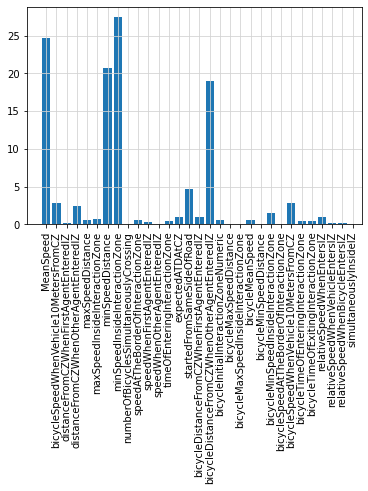

In [34]:
data = getConflictEventsAdjustedForModel()
findSignificantFeatures(data, allFeatures)


### AIC = Akaike’s Information Criterion

__AIC = -2(log-likelihood) + 2K__
* K is the number of model parameters (the number of variables in the model plus the intercept).
* Log-likelihood is a measure of model fit. The higher the number, the better the fit. This is usually obtained from statistical output.


AIC compares the quality of a set of statistical models to each other. For example, you might be interested in what variables contribute to low socioeconomic status and how the variables contribute to that status.

Although the AIC will choose the best model from a set, it won’t say anything about absolute quality. In other words, if all of your models are poor, it will choose the best of a bad bunch. 

## Log likelihood per model

* Based on equations in Silavnos paper
* Based on this: https://stackoverflow.com/questions/48185090/how-to-get-the-log-likelihood-for-a-logistic-regression-model-in-sklearn

In [35]:
def getLogLikelihood(y_true, y_pred_p):
    
    log_likelihood_elements = y_true*np.log(y_pred_p[:,1]) + (1-y_true)*np.log(1-y_pred_p[:,1])
    print(' Log likelihood: ', np.sum(log_likelihood_elements))
    
    return np.sum(log_likelihood_elements)
    
    ''' 
    logs = []
    
    for i, p in enumerate(y_pred_p):
        p_1 = p[1]
        p_0 = p[0]
        
        y = y_true[i]
        
        log = np.log((p_1**y)*(p_0**(1-y)))
        logs.append(log)
    
    
    log_likelihood = np.sum(logs)
    print('Log likelihood: ', log_likelihood)
    #log_likelihood_elements = y_true*np.log(y_pred) + (1-y_true)*np.log(1-y_pred)
    '''
    

## R-squared score

https://datascience.oneoffcoder.com/psuedo-r-squared-logistic-regression.html

In [36]:
def getEfronsRSquared(y_true, y_pred):
    n = float(len(y_true))
    
    a = np.power(y_true - y_pred, 2.0)
    b = np.power((y_true - (np.sum(y_true) / n)), 2.0)
    
    sum_a = np.sum(a)
    sum_b = np.sum(b)
        
    R2 = 1 - (sum_a/sum_b)
    return R2
    










#  Logistic Regression Models 

* Predict vehicle perceiving a coonflict probability
* Predict vehicle yielding probability




In [37]:
# --- Train model ---

def trainModel(data, features):
    # Features
    X = data[features] 

    # Get probability
    y = data.yielded # Target variable   

    # Separate Training and test data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)
    
    # Fit the model with data
    logreg = LogisticRegression() # solver='liblinear', verbose=1
    logreg.fit(X_train, y_train)
    
    return logreg, X_test, y_test


# ---- Logistic Regression ---
# a logit model is applied to model the vehicle‐bicycle interaction process

def predictYieldingDecision(data, features):     
    logreg, X_test, y_test = trainModel(data, features)

    y_pred = logreg.predict(X_test)
    y_prob = logreg.predict_proba(X_test)
    
    log_likelihood_based_on_loss = -(log_loss(y_test, y_prob))*len(y_test)
    minus_2_LL = -2 * log_likelihood_based_on_loss
    
    rSquared = getEfronsRSquared(y_test.values, y_prob[:,1])
    
    getPValuePerModel(features)
    
    yielding_probabilities = [probabilities[1] for probabilities in y_prob]
    
    print('Feature coeficents: ', logreg.coef_)
    
    print("Efron's R squared", rSquared)
    print('Log likelihood:', log_likelihood_based_on_loss)
    print('-2 log likelihood:', minus_2_LL)
    # Classification rate
    print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
    # How many selected items are relevant?
    print("Precision:", metrics.precision_score(y_test, y_pred, zero_division=0))
    # How many relevant items are selected?
    print("Recall:", metrics.recall_score(y_test, y_pred))

    return yielding_probabilities, X_test


### Plot model results

In [41]:
from matplotlib.collections import LineCollection
from mpl_toolkits.mplot3d import Axes3D
import plotly
import plotly.graph_objs as go
import plotly.express as px


def plot3DScatterPlot(x, y, z, xLabel, yLabel, zLabel):
    fig = plt.figure()

    ax = plt.axes(projection='3d', xlabel=xLabel, ylabel=yLabel, zlabel=zLabel)

    # Data for three-dimensional scattered points
    ax.scatter3D(x, y, z, c=z, cmap='Blues');
    

def defPlot2DWithColour(x, y, z, xLabel, yLabel, zLabel, title):
    
    #x_ = np.tile(x, 7)
    #segs = np.stack((x_, y), axis=1).reshape(7, 4, 2)

    plt.figure()
    plt.title(title)
    plt.xlabel(xLabel)
    plt.ylabel(yLabel)
    plt.grid(b=True, color='#D3D3D3')
    #plt.ylabel('Probability')
    
    sc = plt.scatter(x, y, c=z, cmap="plasma")
    plt.colorbar()

    #lc = LineCollection(segs, cmap="plasma", array=np.unique(z))
    #plt.gca().add_collection(lc)

    plt.show()
    return plt


def plot4DWithColour(testData, x, y, z, q, p, xLabel, yLabel, zLabel, qLabel, pLabel, title):

    fig1 = px.scatter_3d(testData, x=xLabel, y=yLabel, z=zLabel, size=qLabel,
              color=pLabel, opacity=0.7)

    
    # tight layout
    fig1.update_layout(margin=dict(l=0, r=0, b=0, t=0), scene = dict(
                    xaxis = dict(
                         backgroundcolor="rgb(255, 255, 255)",
                         gridcolor="rgb(229, 236, 246)",
                         showbackground=True,
                         zerolinecolor="white",),
                    yaxis = dict(
                        backgroundcolor="rgb(255, 255,255)",
                        gridcolor="rgb(229, 236, 246)",
                        showbackground=True,
                        zerolinecolor="white"),
                    zaxis = dict(
                        backgroundcolor="rgb(255, 255,255)",
                        gridcolor="rgb(229, 236, 246)",
                        showbackground=True,
                        zerolinecolor="white",),),)
    return fig1
    


In [42]:

def plotYieldingProbabilityRelativeToFeature(featureNames, useOnlyConflictEvents=True, plot1D=True, plot4D=False):
    
    if isinstance(featureNames, list) == True:
        feature_cols = featureNames
    else:
        feature_cols = [featureNames]
    
    
    if useOnlyConflictEvents == True:
        data = getConflictEventsAdjustedForModel()
        title = 'Yielding probability'

    else:
        data = getEventsWithConflictLabelAdjustedForModel()
        title = 'Conflict probability'
        
    probabilities, testData = predictYieldingDecision(data, feature_cols)
    
    if plot4D == True:
        
        firstFeatureValues = testData[feature_cols[0]].values
        firstFeatureName = featureNames[0]
        secondFeatureValues = testData[feature_cols[1]].values
        secondFeatureName = featureNames[1]
        thirdFeatureValues = testData[feature_cols[2]].values
        thirdFeatureName = featureNames[2]
        fourthFeatureValues = testData[feature_cols[3]].values
        fourthFeatureName = featureNames[3]
        
        x = firstFeatureValues
        y = secondFeatureValues
        z = thirdFeatureValues
        q = fourthFeatureValues
        p = probabilities
        
        testData['Probabilities'] = p
        
        plot = plot4DWithColour(testData, x, y, z, q, p, xLabel=firstFeatureName, yLabel=secondFeatureName,
                                zLabel=thirdFeatureName, qLabel=fourthFeatureName, pLabel='Probabilities', title=title)

        return plot
    
    
    if isinstance(featureNames, (list, tuple, np.ndarray)) == False or plot1D == True:
        firstFeatureValues = testData[feature_cols[0]].values
        
        plt.title(title)
        plt.xlabel(featureNames)
        plt.ylabel('Probability')

        plt.grid(b=True, color='#D3D3D3')
        plt.scatter(firstFeatureValues, probabilities, color='dodgerblue')
        return plt

    # Plot hetmap
    if isinstance(featureNames, (list, tuple, np.ndarray)) == True:
        firstFeatureValues = testData[feature_cols[0]].values
        firstFeatureName = featureNames[0]
        secondFeatureValues = testData[feature_cols[1]].values
        secondFeatureName = featureNames[1]
        
        
        x = firstFeatureValues
        y = secondFeatureValues
        z = probabilities
        
        #plot3DScatterPlot(x, y, z, xLabel=firstFeatureName, yLabel=secondFeatureName, zLabel='Probabilities')
    
        plot = defPlot2DWithColour(x, y, z, xLabel=firstFeatureName, yLabel=secondFeatureName, zLabel='Probabilities', title=title)
    
        return plot



In [43]:
M3_features = ['bicycleDistanceFromCZWhenOtherAgentEnteredIZ',
              'MeanSpeed', 'minSpeedDistance', 'minSpeedInsideInteractionZone']
plot = plotYieldingProbabilityRelativeToFeature(M3_features, plot1D=False, plot4D=True)
plot.show()

Number of interactions (possible conflict events):  150
Number of interactions: 150
Number of conflict events: 52
Number of yield events (out of conflict events): 38
Number of interactions (possible conflict events):  150
Number of interactions: 150
Number of conflict events: 52
Number of yield events (out of conflict events): 38
['bicycleDistanceFromCZWhenOtherAgentEnteredIZ', 'MeanSpeed', 'minSpeedDistance', 'minSpeedInsideInteractionZone']
 --- P value per model ---  0.00025531269659669303
Feature coeficents:  [[-0.23323464 -0.4568373   0.5746988   0.1949519 ]]
Efron's R squared 0.8259326023799946
Log likelihood: -2.175172717607789
-2 log likelihood: 4.350345435215578
Accuracy: 0.9444444444444444
Precision: 0.9230769230769231
Recall: 1.0


## Conflict probability

### Estimating conflict probability
However seems like the model keeps giving incorrect results which is most probably due to having too few data (we have 69 interactions while in Silvano et al. paper there is 187 interactions).

Therefore we set the treshold that distinguishes conflict and non-conflict events manually based on video recordings and the yielding probability plot. 
We set the treshold to be 5 seconds.

Should be something similar to this because we have also assumed that if vehicle and bicycle reach the IZ at the same time then they are definitely experiencing a conflict but because of too few data it is not the case.

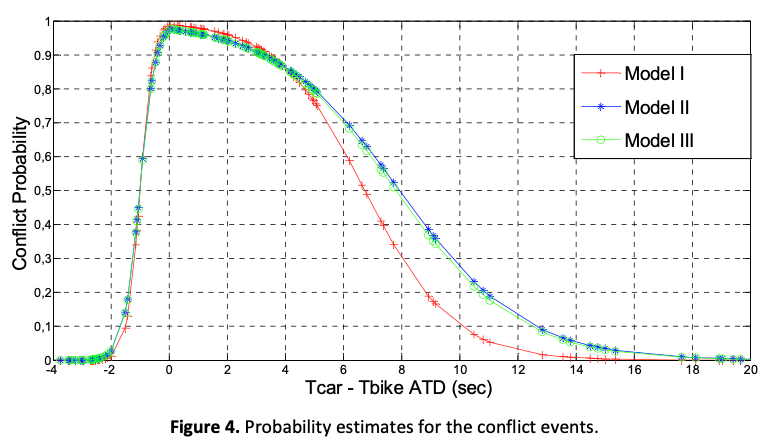

Number of interactions (possible conflict events):  150
Number of interactions (possible conflict events):  150
Number of interactions: 150
Number of conflict events: 52
Number of yield events (out of conflict events): 38
['bicycleEnteredFirstATD', 'vehicleEnteredFirstATD']
 --- P value per model ---  0.1164435894230355
Feature coeficents:  [[-0.45809591  1.3003803 ]]
Efron's R squared 0.5090090780083696
Log likelihood: -15.897225017419302
-2 log likelihood: 31.794450034838604
Accuracy: 0.88
Precision: 0.7222222222222222
Recall: 0.9285714285714286


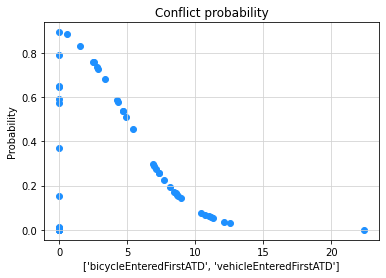

Number of interactions (possible conflict events):  150
Number of interactions (possible conflict events):  150
Number of interactions: 150
Number of conflict events: 52
Number of yield events (out of conflict events): 38
['vehicleEnteredFirstATD', 'bicycleEnteredFirstATD']
 --- P value per model ---  0.1164435894230355
Feature coeficents:  [[ 1.3003803  -0.45809591]]
Efron's R squared 0.5090090780083696
Log likelihood: -15.897225017419302
-2 log likelihood: 31.794450034838604
Accuracy: 0.88
Precision: 0.7222222222222222
Recall: 0.9285714285714286


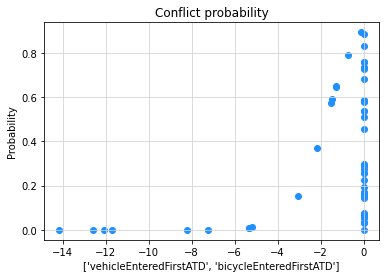

Number of interactions (possible conflict events):  150
Number of interactions (possible conflict events):  150
Number of interactions: 150
Number of conflict events: 52
Number of yield events (out of conflict events): 38
['arrivalTimeDifference', 'vehicleEnteredFirstATD', 'bicycleEnteredFirstATD']
 --- P value per model ---  0.20055104320669517
Feature coeficents:  [[ 0.28959795  1.03893454 -0.74933658]]
Efron's R squared 0.5120582443842738
Log likelihood: -15.820964054952041
-2 log likelihood: 31.641928109904082
Accuracy: 0.88
Precision: 0.7222222222222222
Recall: 0.9285714285714286


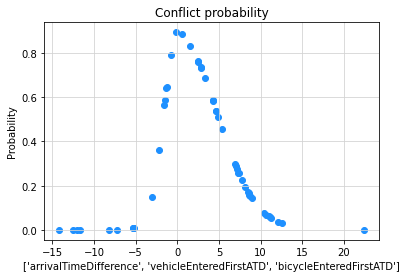

In [45]:
plot = plot = plotYieldingProbabilityRelativeToFeature(['bicycleEnteredFirstATD', 'vehicleEnteredFirstATD'],useOnlyConflictEvents=False, plot1D=True)
plot.show()

plot = plotYieldingProbabilityRelativeToFeature(['vehicleEnteredFirstATD', 'bicycleEnteredFirstATD'], useOnlyConflictEvents=False, plot1D=True)
plot.show()

plot = plotYieldingProbabilityRelativeToFeature(['arrivalTimeDifference','vehicleEnteredFirstATD', 'bicycleEnteredFirstATD'], useOnlyConflictEvents=False, plot1D=True)
plot.show()



Based on the plots above we can define the arrival time difference that distinguishes between conflict and non-conflict events. Accordint to the plot the __conflict probability drops below 50% at around -2.5 and +5 seconds__. Therefore, we choose the ATD threshold to be -2.5 and +5 seconds for distinguishing the conflct events.

## Recreate best model from Silvano et al. paper



The features used in the best model (Model nr III) from the paper re visible from the images below:


<table><tr>
<td> 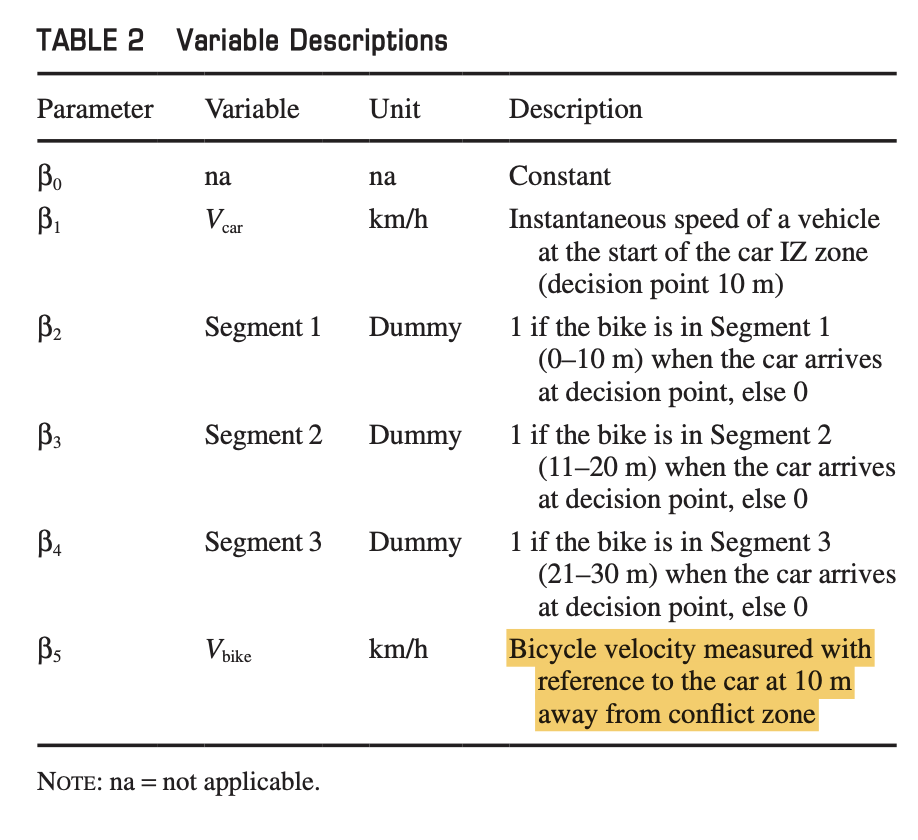 </td>
<td> 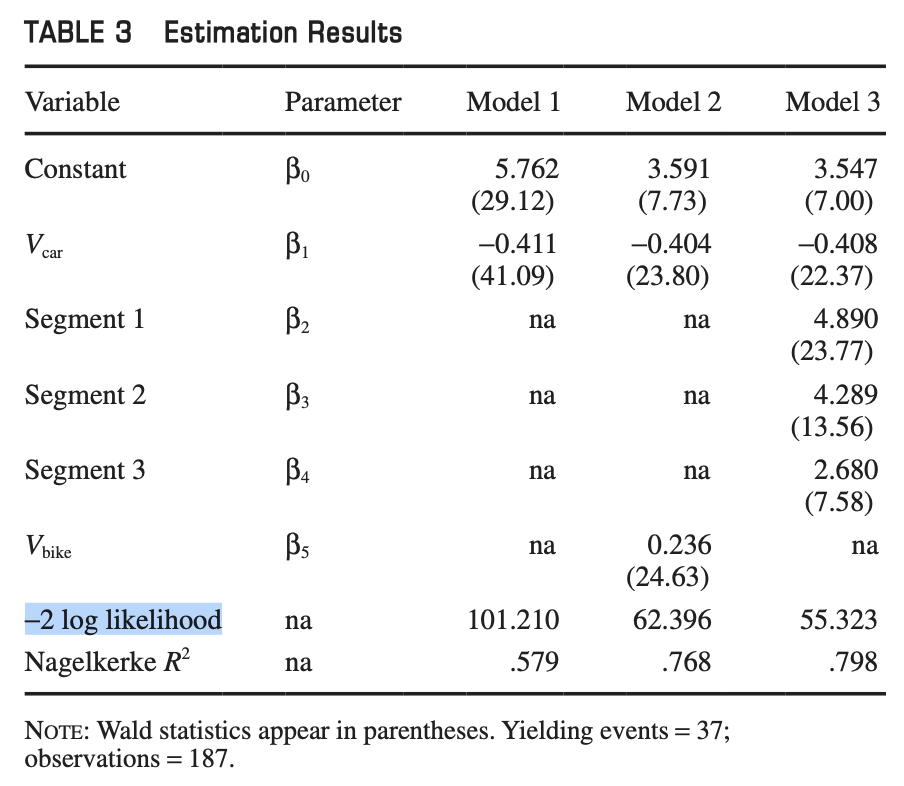 </td>
</tr></table>


Number of interactions (possible conflict events):  150
Number of interactions: 150
Number of conflict events: 52
Number of yield events (out of conflict events): 38
Number of interactions (possible conflict events):  150
Number of interactions: 150
Number of conflict events: 52
Number of yield events (out of conflict events): 38
['speedAtTheBorderOfInteractionZone', 'bicycleDistanceFromCZWhenOtherAgentEnteredIZ']
 --- P value per model ---  0.11987098496317311
Feature coeficents:  [[-0.07214647 -0.08531624]]
Efron's R squared 0.11801842909843074
Log likelihood: -10.687791271575962
-2 log likelihood: 21.375582543151925
Accuracy: 0.7222222222222222
Precision: 0.7058823529411765
Recall: 1.0


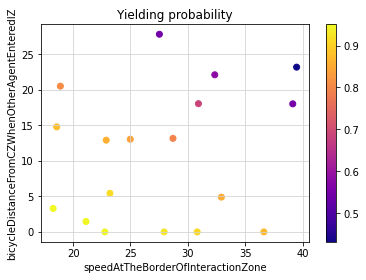

In [47]:
features = ['speedAtTheBorderOfInteractionZone','bicycleDistanceFromCZWhenOtherAgentEnteredIZ']
plot = plotYieldingProbabilityRelativeToFeature(features, plot1D=False)
plot.show()


Number of interactions (possible conflict events):  150
Number of interactions: 150
Number of conflict events: 52
Number of yield events (out of conflict events): 38
Number of interactions (possible conflict events):  150
Number of interactions: 150
Number of conflict events: 52
Number of yield events (out of conflict events): 38
['speedAtTheBorderOfInteractionZone', 'expectedATDAtCZ']
 --- P value per model ---  0.06278745779418936
Feature coeficents:  [[ 0.02963117 -0.09140294]]
Efron's R squared -0.12297320783134746
Log likelihood: -13.368047475286103
-2 log likelihood: 26.736094950572205
Accuracy: 0.6666666666666666
Precision: 0.6666666666666666
Recall: 1.0


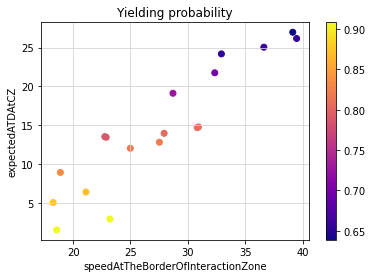

In [48]:
features = ['speedAtTheBorderOfInteractionZone','expectedATDAtCZ']
plot = plotYieldingProbabilityRelativeToFeature(features, plot1D=False)
plot.show()


Number of interactions (possible conflict events):  150
Number of interactions: 150
Number of conflict events: 52
Number of yield events (out of conflict events): 38
Number of interactions (possible conflict events):  150
Number of interactions: 150
Number of conflict events: 52
Number of yield events (out of conflict events): 38
['minSpeedDistance', 'bicycleDistanceFromCZWhenOtherAgentEnteredIZ']
 --- P value per model ---  0.00017733683448914556
Feature coeficents:  [[ 0.82099715 -0.19118285]]
Efron's R squared 0.7494140469980729
Log likelihood: -3.0241957056679047
-2 log likelihood: 6.0483914113358095
Accuracy: 0.9444444444444444
Precision: 1.0
Recall: 0.9166666666666666


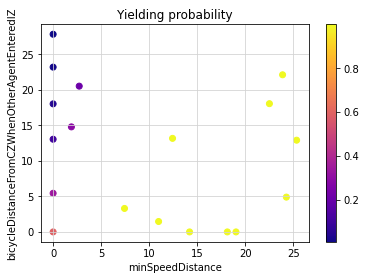

In [49]:
features = ['minSpeedDistance', 'bicycleDistanceFromCZWhenOtherAgentEnteredIZ']
plot = plotYieldingProbabilityRelativeToFeature(features, plot1D=False)
plot.show()


Number of interactions (possible conflict events):  150
Number of interactions: 150
Number of conflict events: 52
Number of yield events (out of conflict events): 38
Number of interactions (possible conflict events):  150
Number of interactions: 150
Number of conflict events: 52
Number of yield events (out of conflict events): 38
['minSpeedDistance', 'expectedATDAtCZ', 'bicycleDistanceFromCZWhenOtherAgentEnteredIZ']
 --- P value per model ---  0.00041330070457753793
Feature coeficents:  [[ 0.76686868 -0.02089667 -0.18398317]]
Efron's R squared 0.7372236134729178
Log likelihood: -3.112626085144983
-2 log likelihood: 6.225252170289966
Accuracy: 0.9444444444444444
Precision: 1.0
Recall: 0.9166666666666666


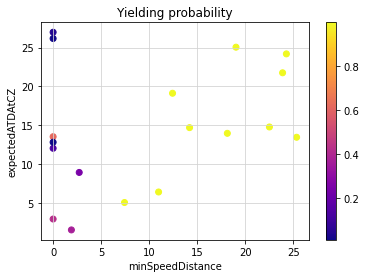

In [50]:
features = ['minSpeedDistance', 'expectedATDAtCZ', 'bicycleDistanceFromCZWhenOtherAgentEnteredIZ']
plot = plotYieldingProbabilityRelativeToFeature(features, plot1D=False)
plot.show()


Number of interactions (possible conflict events):  150
Number of interactions: 150
Number of conflict events: 52
Number of yield events (out of conflict events): 38
Number of interactions (possible conflict events):  150
Number of interactions: 150
Number of conflict events: 52
Number of yield events (out of conflict events): 38
['bicycleDistanceFromCZWhenOtherAgentEnteredIZ', 'expectedATDAtCZ']
 --- P value per model ---  0.07906844061930758
Feature coeficents:  [[-0.07870718 -0.06182549]]
Efron's R squared 0.05653335979557361
Log likelihood: -11.600447893441679
-2 log likelihood: 23.200895786883358
Accuracy: 0.7222222222222222
Precision: 0.7058823529411765
Recall: 1.0


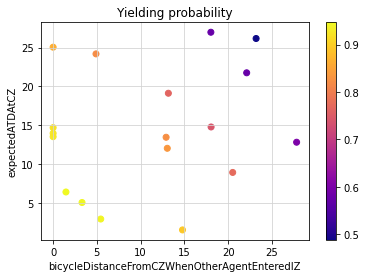

In [51]:
features = ['bicycleDistanceFromCZWhenOtherAgentEnteredIZ', 'expectedATDAtCZ']
plot = plotYieldingProbabilityRelativeToFeature(features, plot1D=False)
plot.show()

### Looking at features found based on the correlation feature selection

Number of interactions (possible conflict events):  150
Number of interactions: 150
Number of conflict events: 52
Number of yield events (out of conflict events): 38
Number of interactions (possible conflict events):  150
Number of interactions: 150
Number of conflict events: 52
Number of yield events (out of conflict events): 38
['bicycleDistanceFromCZWhenOtherAgentEnteredIZ', 'minSpeedDistance']
 --- P value per model ---  0.00017733683448914556
Feature coeficents:  [[-0.19118285  0.82099715]]
Efron's R squared 0.7494140469980729
Log likelihood: -3.0241957056679047
-2 log likelihood: 6.0483914113358095
Accuracy: 0.9444444444444444
Precision: 1.0
Recall: 0.9166666666666666


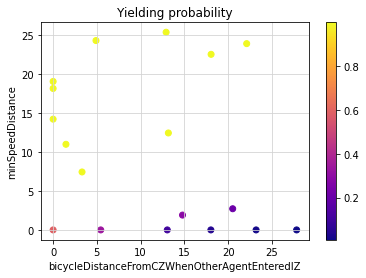

In [52]:
M1_features = ['speedAtTheBorderOfInteractionZone', 'bicycleDistanceFromCZWhenOtherAgentEnteredIZ']
M2_features = ['speedAtTheBorderOfInteractionZone', 'bicycleDistanceFromCZWhenOtherAgentEnteredIZ',
              'MeanSpeed', 'minSpeedDistance', 'minSpeedInsideInteractionZone']
M3_features = ['bicycleDistanceFromCZWhenOtherAgentEnteredIZ',
              'MeanSpeed', 'minSpeedDistance', 'minSpeedInsideInteractionZone']
M4_features = ['MeanSpeed', 'minSpeedDistance', 'minSpeedInsideInteractionZone']
M5_features = ['bicycleDistanceFromCZWhenOtherAgentEnteredIZ',
              'minSpeedDistance', 'minSpeedInsideInteractionZone']
M6_features = ['bicycleDistanceFromCZWhenOtherAgentEnteredIZ', 'minSpeedDistance']
M7_features = ['bicycleDistanceFromCZWhenOtherAgentEnteredIZ', 'minSpeedInsideInteractionZone']


models = [M1_features, M2_features, M3_features, M4_features, M5_features, M6_features, M7_features]

# speedAtTheBorderOfInteractionZone

# bicycleDistanceFromCZWhenOtherAgentEnteredIZ
# minSpeedDistance
# minSpeedInsideInteractionZone

features = ['bicycleDistanceFromCZWhenOtherAgentEnteredIZ', 'minSpeedDistance']
plot = plotYieldingProbabilityRelativeToFeature(features, plot1D=False)
plot.show()


## Hypothesis: 
### Vehicle yielding rate increases with lower vehicle speed.

Number of interactions (possible conflict events):  150
Number of interactions: 150
Number of conflict events: 52
Number of yield events (out of conflict events): 38
Number of interactions (possible conflict events):  150
Number of interactions: 150
Number of conflict events: 52
Number of yield events (out of conflict events): 38
Number of interactions (possible conflict events):  150
Number of interactions: 150
Number of conflict events: 52
Number of yield events (out of conflict events): 38
['MeanSpeed']
 --- P value per model ---  0.00024730482704262883
Feature coeficents:  [[-0.26754179]]
Efron's R squared 0.5413154754379442
Log likelihood: -5.824836091481238
-2 log likelihood: 11.649672182962476
Accuracy: 0.8333333333333334
Precision: 0.8
Recall: 1.0


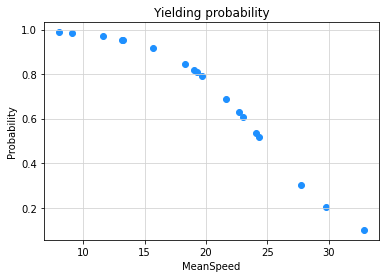

Number of interactions (possible conflict events):  150
Number of interactions: 150
Number of conflict events: 52
Number of yield events (out of conflict events): 38
Number of interactions (possible conflict events):  150
Number of interactions: 150
Number of conflict events: 52
Number of yield events (out of conflict events): 38
['speedAtTheBorderOfInteractionZone']
 --- P value per model ---  0.5863009295979076
Feature coeficents:  [[-0.06333248]]
Efron's R squared -0.028273473108080927
Log likelihood: -11.926904647931188
-2 log likelihood: 23.853809295862376
Accuracy: 0.6666666666666666
Precision: 0.6666666666666666
Recall: 1.0


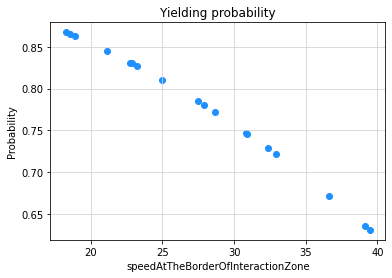

Number of interactions (possible conflict events):  150
Number of interactions: 150
Number of conflict events: 52
Number of yield events (out of conflict events): 38
Number of interactions (possible conflict events):  150
Number of interactions: 150
Number of conflict events: 52
Number of yield events (out of conflict events): 38
['minSpeedInsideInteractionZone']
 --- P value per model ---  0.003306898988817181
Feature coeficents:  [[-0.22465042]]
Efron's R squared 0.3858775055575814
Log likelihood: -7.157101886423665
-2 log likelihood: 14.31420377284733
Accuracy: 0.7777777777777778
Precision: 0.8333333333333334
Recall: 0.8333333333333334


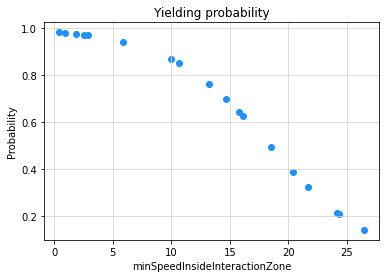

Number of interactions (possible conflict events):  150
Number of interactions: 150
Number of conflict events: 52
Number of yield events (out of conflict events): 38
Number of interactions (possible conflict events):  150
Number of interactions: 150
Number of conflict events: 52
Number of yield events (out of conflict events): 38
['minSpeedDistance']
 --- P value per model ---  9.860767618348698e-05
Feature coeficents:  [[0.358901]]
Efron's R squared 0.6631341405989187
Log likelihood: -4.396711088453788
-2 log likelihood: 8.793422176907576
Accuracy: 0.8888888888888888
Precision: 1.0
Recall: 0.8333333333333334


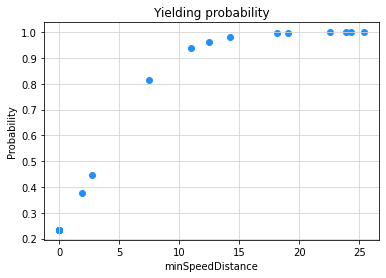

Number of interactions (possible conflict events):  150
Number of interactions: 150
Number of conflict events: 52
Number of yield events (out of conflict events): 38
Number of interactions (possible conflict events):  150
Number of interactions: 150
Number of conflict events: 52
Number of yield events (out of conflict events): 38
['maxSpeedInsideInteractionZone']
 --- P value per model ---  0.0767088135429965
Feature coeficents:  [[-0.04181475]]
Efron's R squared 0.03377126041870604
Log likelihood: -11.160980859486768
-2 log likelihood: 22.321961718973537
Accuracy: 0.6666666666666666
Precision: 0.6666666666666666
Recall: 1.0


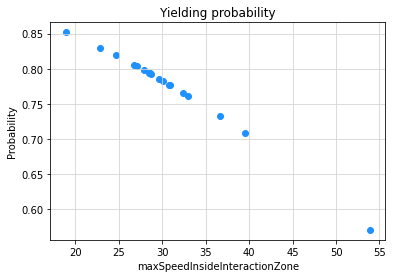

Number of interactions (possible conflict events):  150
Number of interactions: 150
Number of conflict events: 52
Number of yield events (out of conflict events): 38
Number of interactions (possible conflict events):  150
Number of interactions: 150
Number of conflict events: 52
Number of yield events (out of conflict events): 38
['maxSpeedDistance']
 --- P value per model ---  0.1266333136076397
Feature coeficents:  [[0.06173524]]
Efron's R squared 0.05868723045275004
Log likelihood: -10.81137694294614
-2 log likelihood: 21.62275388589228
Accuracy: 0.6666666666666666
Precision: 0.6666666666666666
Recall: 1.0


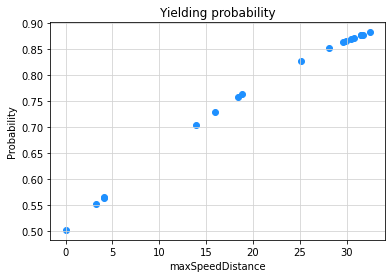

In [53]:
specificData = getConflictEventsAdjustedForModel()

plot = plotYieldingProbabilityRelativeToFeature('MeanSpeed')
plot.show()
plot = plotYieldingProbabilityRelativeToFeature('speedAtTheBorderOfInteractionZone')
plot.show()
plot = plotYieldingProbabilityRelativeToFeature('minSpeedInsideInteractionZone')
plot.show()
plot = plotYieldingProbabilityRelativeToFeature('minSpeedDistance')
plot.show()

plot = plotYieldingProbabilityRelativeToFeature('maxSpeedInsideInteractionZone')
plot.show()
plot = plotYieldingProbabilityRelativeToFeature('maxSpeedDistance')
plot.show()


### Vehicle yielding rate increases with higher bicycle speed.

Number of interactions (possible conflict events):  150
Number of interactions: 150
Number of conflict events: 52
Number of yield events (out of conflict events): 38
Number of interactions (possible conflict events):  150
Number of interactions: 150
Number of conflict events: 52
Number of yield events (out of conflict events): 38
Number of interactions (possible conflict events):  150
Number of interactions: 150
Number of conflict events: 52
Number of yield events (out of conflict events): 38
['bicycleMeanSpeed']
 --- P value per model ---  0.16284932360126708
Feature coeficents:  [[0.09693141]]
Efron's R squared -0.12158084767061439
Log likelihood: -12.874234776542018
-2 log likelihood: 25.748469553084036
Accuracy: 0.6666666666666666
Precision: 0.6666666666666666
Recall: 1.0


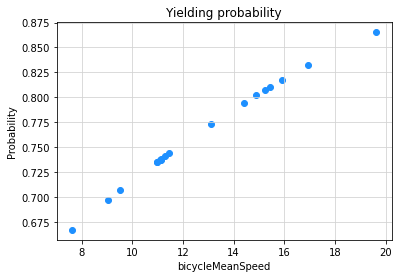

Number of interactions (possible conflict events):  150
Number of interactions: 150
Number of conflict events: 52
Number of yield events (out of conflict events): 38
Number of interactions (possible conflict events):  150
Number of interactions: 150
Number of conflict events: 52
Number of yield events (out of conflict events): 38
['bicycleSpeedAtTheBorderOfInteractionZone']
 --- P value per model ---  0.022237000729888833
Feature coeficents:  [[0.04247568]]
Efron's R squared -0.10324064935855404
Log likelihood: -12.587089743209525
-2 log likelihood: 25.17417948641905
Accuracy: 0.6666666666666666
Precision: 0.6666666666666666
Recall: 1.0


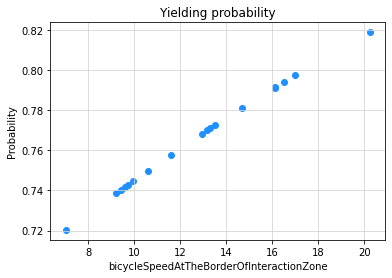

Number of interactions (possible conflict events):  150
Number of interactions: 150
Number of conflict events: 52
Number of yield events (out of conflict events): 38
Number of interactions (possible conflict events):  150
Number of interactions: 150
Number of conflict events: 52
Number of yield events (out of conflict events): 38
['bicycleMinSpeedInsideInteractionZone']
 --- P value per model ---  0.7112128504506843
Feature coeficents:  [[0.11899167]]
Efron's R squared -0.07971600086665198
Log likelihood: -12.365562333955584
-2 log likelihood: 24.731124667911168
Accuracy: 0.6666666666666666
Precision: 0.6666666666666666
Recall: 1.0


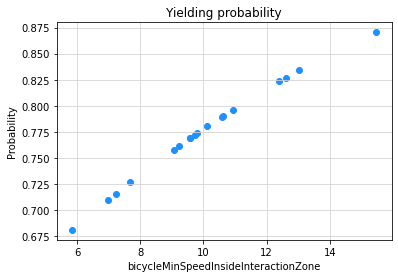

Number of interactions (possible conflict events):  150
Number of interactions: 150
Number of conflict events: 52
Number of yield events (out of conflict events): 38
Number of interactions (possible conflict events):  150
Number of interactions: 150
Number of conflict events: 52
Number of yield events (out of conflict events): 38
['bicycleMinSpeedDistance']
 --- P value per model ---  0.44768751742714885
Feature coeficents:  [[-0.04469848]]
Efron's R squared -0.10338103442027902
Log likelihood: -12.508785159657837
-2 log likelihood: 25.017570319315674
Accuracy: 0.6666666666666666
Precision: 0.6666666666666666
Recall: 1.0


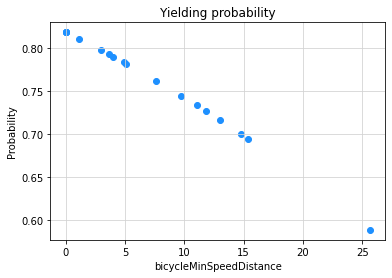

Number of interactions (possible conflict events):  150
Number of interactions: 150
Number of conflict events: 52
Number of yield events (out of conflict events): 38
Number of interactions (possible conflict events):  150
Number of interactions: 150
Number of conflict events: 52
Number of yield events (out of conflict events): 38
['bicycleMaxSpeedInsideInteractionZone']
 --- P value per model ---  0.015163567789267224
Feature coeficents:  [[0.08619495]]
Efron's R squared -0.15879886253239506
Log likelihood: -13.254923488801708
-2 log likelihood: 26.509846977603416
Accuracy: 0.6666666666666666
Precision: 0.6666666666666666
Recall: 1.0


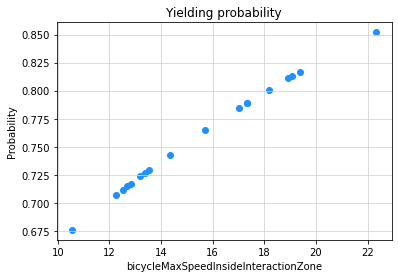

Number of interactions (possible conflict events):  150
Number of interactions: 150
Number of conflict events: 52
Number of yield events (out of conflict events): 38
Number of interactions (possible conflict events):  150
Number of interactions: 150
Number of conflict events: 52
Number of yield events (out of conflict events): 38
['bicycleMaxSpeedDistance']
 --- P value per model ---  0.21343651931690485
Feature coeficents:  [[0.30084038]]
Efron's R squared -0.11993187946979744
Log likelihood: -15.361465265520064
-2 log likelihood: 30.722930531040127
Accuracy: 0.6666666666666666
Precision: 0.6666666666666666
Recall: 1.0


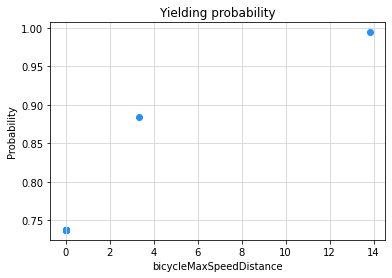

In [54]:
specificData = getConflictEventsAdjustedForModel()

plot = plotYieldingProbabilityRelativeToFeature('bicycleMeanSpeed')
plot.show()
plot = plotYieldingProbabilityRelativeToFeature('bicycleSpeedAtTheBorderOfInteractionZone')
plot.show()
plot = plotYieldingProbabilityRelativeToFeature('bicycleMinSpeedInsideInteractionZone')
plot.show()
plot = plotYieldingProbabilityRelativeToFeature('bicycleMinSpeedDistance')
plot.show()

plot = plotYieldingProbabilityRelativeToFeature('bicycleMaxSpeedInsideInteractionZone')
plot.show()
plot = plotYieldingProbabilityRelativeToFeature('bicycleMaxSpeedDistance')
plot.show()

### Vehicle yielding rate decreases together with higher vehicle speed and cyclist’s long-er distance from the conflict zone.

Number of interactions (possible conflict events):  150
Number of interactions: 150
Number of conflict events: 52
Number of yield events (out of conflict events): 38
Number of interactions (possible conflict events):  150
Number of interactions: 150
Number of conflict events: 52
Number of yield events (out of conflict events): 38
['bicycleDistanceFromCZWhenFirstAgentEnteredIZ']
 --- P value per model ---  0.34647199741731594
Feature coeficents:  [[-0.04517472]]
Efron's R squared -0.09253926637931564
Log likelihood: -7.534577128588419
-2 log likelihood: 15.069154257176837
Accuracy: 0.7692307692307693
Precision: 0.7692307692307693
Recall: 1.0


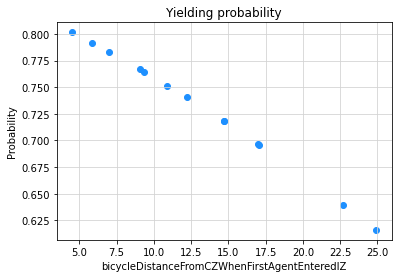

Number of interactions (possible conflict events):  150
Number of interactions: 150
Number of conflict events: 52
Number of yield events (out of conflict events): 38
Number of interactions (possible conflict events):  150
Number of interactions: 150
Number of conflict events: 52
Number of yield events (out of conflict events): 38
['distanceFromCZWhenOtherAgentEnteredIZ']
 --- P value per model ---  0.5859427038379856
Feature coeficents:  [[0.08104167]]
Efron's R squared -0.1367402135215614
Log likelihood: -7.457008807839225
-2 log likelihood: 14.91401761567845
Accuracy: 0.6153846153846154
Precision: 0.7272727272727273
Recall: 0.8


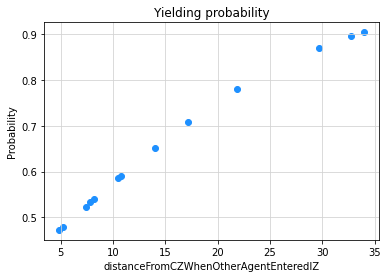

Number of interactions (possible conflict events):  150
Number of interactions: 150
Number of conflict events: 52
Number of yield events (out of conflict events): 38
Number of interactions (possible conflict events):  150
Number of interactions: 150
Number of conflict events: 52
Number of yield events (out of conflict events): 38
['bicycleDistanceFromCZWhenOtherAgentEnteredIZ']
 --- P value per model ---  0.26076147899398994
Feature coeficents:  [[-0.09518843]]
Efron's R squared 0.033525011170284946
Log likelihood: -6.578044230765282
-2 log likelihood: 13.156088461530564
Accuracy: 0.7692307692307693
Precision: 0.7692307692307693
Recall: 1.0


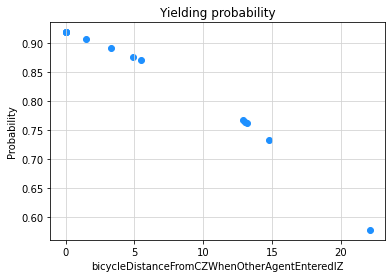

In [131]:
plot = plotYieldingProbabilityRelativeToFeature('bicycleDistanceFromCZWhenFirstAgentEnteredIZ')
plot.show()
plot = plotYieldingProbabilityRelativeToFeature('distanceFromCZWhenOtherAgentEnteredIZ')
plot.show()
plot = plotYieldingProbabilityRelativeToFeature('bicycleDistanceFromCZWhenOtherAgentEnteredIZ')
plot.show()



## Models

Number of interactions (possible conflict events):  150
Number of interactions: 150
Number of conflict events: 52
Number of yield events (out of conflict events): 38
Number of interactions (possible conflict events):  150
Number of interactions: 150
Number of conflict events: 52
Number of yield events (out of conflict events): 38
['bicycleDistanceFromCZWhenOtherAgentEnteredIZ', 'minSpeedInsideInteractionZone']
 --- P value per model ---  0.0003269783962831028
Feature coeficents:  [[-0.12659025 -0.24865048]]
Efron's R squared 0.6135402362260469
Log likelihood: -4.84844532770143
-2 log likelihood: 9.69689065540286
Accuracy: 0.8888888888888888
Precision: 0.8571428571428571
Recall: 1.0


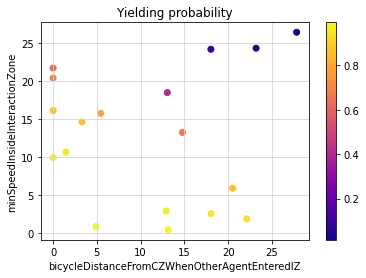

Number of interactions (possible conflict events):  150
Number of interactions: 150
Number of conflict events: 52
Number of yield events (out of conflict events): 38
Number of interactions (possible conflict events):  150
Number of interactions: 150
Number of conflict events: 52
Number of yield events (out of conflict events): 38
['bicycleDistanceFromCZWhenOtherAgentEnteredIZ', 'minSpeedDistance']
 --- P value per model ---  0.00017733683448914556
Feature coeficents:  [[-0.19118285  0.82099715]]
Efron's R squared 0.7494140469980729
Log likelihood: -3.0241957056679047
-2 log likelihood: 6.0483914113358095
Accuracy: 0.9444444444444444
Precision: 1.0
Recall: 0.9166666666666666


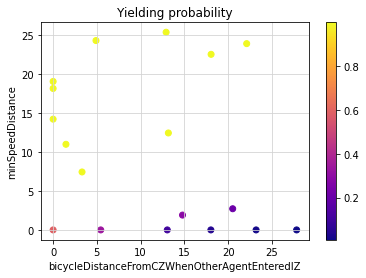

Number of interactions (possible conflict events):  150
Number of interactions: 150
Number of conflict events: 52
Number of yield events (out of conflict events): 38
Number of interactions (possible conflict events):  150
Number of interactions: 150
Number of conflict events: 52
Number of yield events (out of conflict events): 38
['bicycleDistanceFromCZWhenOtherAgentEnteredIZ', 'speedAtTheBorderOfInteractionZone']
 --- P value per model ---  0.11987098496317311
Feature coeficents:  [[-0.08531624 -0.07214647]]
Efron's R squared 0.11801842909843074
Log likelihood: -10.687791271575962
-2 log likelihood: 21.375582543151925
Accuracy: 0.7222222222222222
Precision: 0.7058823529411765
Recall: 1.0


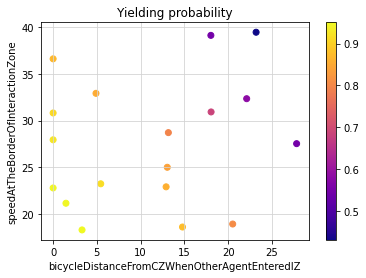

Number of interactions (possible conflict events):  150
Number of interactions: 150
Number of conflict events: 52
Number of yield events (out of conflict events): 38
Number of interactions (possible conflict events):  150
Number of interactions: 150
Number of conflict events: 52
Number of yield events (out of conflict events): 38
['bicycleDistanceFromCZWhenOtherAgentEnteredIZ', 'MeanSpeed']
 --- P value per model ---  4.239525043787758e-05
Feature coeficents:  [[-0.20676135 -0.38214038]]
Efron's R squared 0.7082235512288448
Log likelihood: -3.619744914324544
-2 log likelihood: 7.239489828649088
Accuracy: 0.8888888888888888
Precision: 0.8571428571428571
Recall: 1.0


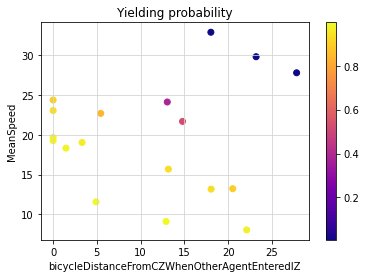

Number of interactions (possible conflict events):  150
Number of interactions: 150
Number of conflict events: 52
Number of yield events (out of conflict events): 38
Number of interactions (possible conflict events):  150
Number of interactions: 150
Number of conflict events: 52
Number of yield events (out of conflict events): 38
['bicycleDistanceFromCZWhenOtherAgentEnteredIZ', 'speedAtTheBorderOfInteractionZone']
 --- P value per model ---  0.11987098496317311
Feature coeficents:  [[-0.08531624 -0.07214647]]
Efron's R squared 0.11801842909843074
Log likelihood: -10.687791271575962
-2 log likelihood: 21.375582543151925
Accuracy: 0.7222222222222222
Precision: 0.7058823529411765
Recall: 1.0


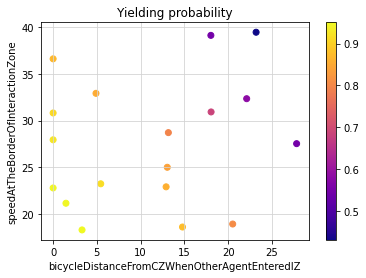

In [136]:
plot = plotYieldingProbabilityRelativeToFeature(['bicycleDistanceFromCZWhenOtherAgentEnteredIZ', 'minSpeedInsideInteractionZone'], plot1D=False)
plot.show()

plot = plotYieldingProbabilityRelativeToFeature(['bicycleDistanceFromCZWhenOtherAgentEnteredIZ', 'minSpeedDistance'], plot1D=False)
plot.show()

plot = plotYieldingProbabilityRelativeToFeature(['bicycleDistanceFromCZWhenOtherAgentEnteredIZ', 'speedAtTheBorderOfInteractionZone'], plot1D=False)
plot.show()

plot = plotYieldingProbabilityRelativeToFeature(['bicycleDistanceFromCZWhenOtherAgentEnteredIZ', 'MeanSpeed'], plot1D=False)
plot.show()

plot = plotYieldingProbabilityRelativeToFeature(['bicycleDistanceFromCZWhenOtherAgentEnteredIZ', 'speedAtTheBorderOfInteractionZone'], plot1D=False)
plot.show()


In [57]:
# plotYieldingProbabilityRelativeToFeature(['MeanSpeed', 'minSpeedDistance'])

In [58]:
# plotYieldingProbabilityRelativeToFeature(['initialInteractionZoneNumeric']) # bicycleInitialInteractionZoneNumeric

# --- Analyse Interactions ---
## Silvano et al. approach 
### Divide interactions into conflict and non-conflict events based on arrival time difference

In [59]:
# ------ Vehicle & Bicycle ------

def getBycicleEvents():
    data = getDataWithoutInvalidBicyclesAndWithAddedFeatures()
    return data.loc[data['AgentType'] == 1]

def getVehicleEvents():
    data = getDataWithoutInvalidBicyclesAndWithAddedFeatures()
    return data.loc[data['AgentType'] == 2]


# ------ General Conflict & Non-conflict ------

def getConflictEvents():
    data = getDataWithoutInvalidBicyclesAndWithAddedFeatures()
    
    # Basically we only take into account vehicle and first bicycle event
    df = data.loc[(data['arrivalTimeDifference'] == data['individualArrivalTimeDifference']) & 
                  (data['arrivalTimeDifference'] >= ATD_TRESHOLD_MIN) & (data['arrivalTimeDifference'] <= ATD_TRESHOLD_MAX)]
                  #(abs(data['individualArrivalTimeDifference']) <= ATD_TRESHOLD)]
    
    uniqueConflictInteractions = df.drop_duplicates(subset=['InteractionID', 'AgentType'], keep="first")
    
    return uniqueConflictInteractions
    
def getNonConflictEvents():    
    data = getDataWithoutInvalidBicyclesAndWithAddedFeatures()
    
    # Basically we only take into account vehicle and first bicycle event
    df_1 = data.loc[(data['arrivalTimeDifference'] == data['individualArrivalTimeDifference'])]
    df = df_1.loc[(df_1['arrivalTimeDifference'] < ATD_TRESHOLD_MIN) | (df_1['arrivalTimeDifference'] > ATD_TRESHOLD_MAX)]
    
    #& (abs(data['individualArrivalTimeDifference']) > ATD_TRESHOLD)]
    
    # For interaction 242 for example there are 2 bicycles with same exact ts for entering the IZ so we just want to keep one of them
    uniqueNonConflictInteractions = df.drop_duplicates(subset=['InteractionID', 'AgentType'], keep="first")
    
    return uniqueNonConflictInteractions

# ------ Non-Conflict ------

def getNonConflictBycicleEvent():
    nonConflictEvents = getNonConflictEvents()
    return nonConflictEvents.loc[nonConflictEvents['AgentType'] == 1]

def getNonConflictVehicleEvent():
    nonConflictEvents = getNonConflictEvents()
    return nonConflictEvents.loc[nonConflictEvents['AgentType'] == 2]

# ------ Conflict ------

def getConflictBycicleEvent():
    conflictEvents = getConflictEvents()
    return conflictEvents.loc[conflictEvents['AgentType'] == 1]

def getConflictVehicleEvent():
    conflictEvents = getConflictEvents()
    return conflictEvents.loc[conflictEvents['AgentType'] == 2]

# ------ Yield ------
# Car yielded

def getYieldBycicleEvent():
    conflictBicycleEvents = getConflictBycicleEvent()
    conflictBicycleEvents.set_index(keys='InteractionID', drop=False, inplace=True)
    conflictVehicleEvents = getConflictVehicleEvent()
    
    # Always Bicycle
    for index, bicycle in conflictBicycleEvents.iterrows():
        interactionID = bicycle['InteractionID']
        bicycleLabel = bicycle['yielded']

        # Find if according vehicle has a different label or there was no yielding at all
        
        vehicle = conflictVehicleEvents.loc[(conflictVehicleEvents['InteractionID'] == interactionID) & (conflictVehicleEvents['AgentType'] == 2)]
        vehicleLabel = vehicle['yielded'].values[0]
        
        if vehicleLabel == bicycleLabel:
            conflictBicycleEvents.drop(index=[interactionID], inplace=True)
            
    return conflictBicycleEvents.loc[conflictBicycleEvents['yielded'] == 0]

def getYieldVehicleEvent():
    conflictVehicleEvents = getConflictVehicleEvent()
    return conflictVehicleEvents.loc[conflictVehicleEvents['yielded'] == 1]


# ------ Non-yield ------
# Car did not yield

def getNonYieldBycicleEvent():
    conflictBicycleEvents = getConflictBycicleEvent()
    
    return conflictBicycleEvents.loc[conflictBicycleEvents['yielded'] == 1]

def getNonYieldVehicleEvent():
    conflictVehicleEvents = getConflictVehicleEvent()
    return conflictVehicleEvents.loc[conflictVehicleEvents['yielded'] == 0]



# ------ Number of conflict events ------

def getNumberOfConflictEvent():
    conflictEvents = getConflictEvents()
    uniqueConflictInteractions = conflictEvents.drop_duplicates(subset=['InteractionID'], keep="first")
    return len(uniqueConflictInteractions)

def getNumberOfNonConflictEvent():
    nonConflictEvents = getNonConflictEvents()
    uniqueNonConflictInteractions = nonConflictEvents.drop_duplicates(subset=['InteractionID'], keep="first")
    return len(uniqueNonConflictInteractions)

    

In [60]:
# ------------------ Multiple Bicycles ------------------

def getVehicleEventsWithMultipleBicycles():
    vehicleEvents = getVehicleEvents()
    return vehicleEvents.loc[vehicleEvents['numberOfBicyclesSimultaneouslyCrossing'] > 1]

def getBicycleEventsWithMultipleBicycles():
    bicycleEvents = getBycicleEvents()
    return bicycleEvents.loc[bicycleEvents['numberOfBicyclesSimultaneouslyCrossing'] > 1]


# ---- Conflict ----

def getConflictBicycleEventsWithMultipleBicycles():
    conflictBicycleEvents = getConflictBycicleEvent()
    return conflictBicycleEvents.loc[conflictBicycleEvents['numberOfBicyclesSimultaneouslyCrossing'] > 1]

def getConflictVehicleEventsWithMultipleBicycles():
    conflictVehicleEvents = getConflictVehicleEvent()
    return conflictVehicleEvents.loc[conflictVehicleEvents['numberOfBicyclesSimultaneouslyCrossing'] > 1]

# ---- Non-Conflict ----

def getConflictBicycleEventsWithMultipleBicycles():
    bicycleEvents = getNonConflictBycicleEvent()
    return bicycleEvents.loc[bicycleEvents['numberOfBicyclesSimultaneouslyCrossing'] > 1]

def getConflictVehicleEventsWithMultipleBicycles():
    vehicleEvents = getNonConflictVehicleEvent()
    return vehicleEvents.loc[vehicleEvents['numberOfBicyclesSimultaneouslyCrossing'] > 1]

# ---- Yield ----

def getYieldBicycleEventsWithMultipleBicycles():
    bicycleEvents = getYieldBycicleEvent()
    return bicycleEvents.loc[(bicycleEvents['yielded'] == 0) & bicycleEvents['numberOfBicyclesSimultaneouslyCrossing'] > 1]

def getYieldVehicleEventsWithMultipleBicycles():
    vehicleEvents = getYieldVehicleEvent()
    return vehicleEvents.loc[(vehicleEvents['yielded'] == 1) & vehicleEvents['numberOfBicyclesSimultaneouslyCrossing'] > 1]


# ---- Non-Yield ----

def getNonYieldBicycleEventsWithMultipleBicycles():
    bicycleEvents = getNonYieldBycicleEvent()
    return bicycleEvents.loc[(bicycleEvents['yielded'] == 1) & bicycleEvents['numberOfBicyclesSimultaneouslyCrossing'] > 1]


def getNonYieldVehicleEventsWithMultipleBicycles():
    vehicleEvents = getNonYieldVehicleEvent()
    return vehicleEvents.loc[(vehicleEvents['yielded'] == 0) & vehicleEvents['numberOfBicyclesSimultaneouslyCrossing'] > 1]



# ###### Visualise

#### Cumulative distribution
The cumulative distribution function (CDF) calculates the cumulative probability for a given x-value. Use the CDF to determine the probability that a random observation that is taken from the population will be less than or equal to a certain value.

In [61]:
def plotYieldCumulativeDistributionBasedOnFeature(featureName, aboutVehicle=True):
    if aboutVehicle == True:
        labelStart = 'Vehicle '
        yieldEvents = getYieldVehicleEvent()
        nonYieldEvents = getNonYieldVehicleEvent()
        
    else: 
        labelStart = 'Vehicle '
        yieldEvents = getYieldBycicleEvent()
        nonYieldEvents = getNonYieldBycicleEvent()
        
    
    # sort the data in ascending order 
    x_4 = np.sort(yieldEvents[featureName]) 
    # get the cdf values of y 
    y_4 = np.arange(len(x_4)) / float(len(x_4)) 

    # sort the data in ascending order 
    x_5 = np.sort(nonYieldEvents[featureName]) 
    # get the cdf values of y 
    y_5 = np.arange(len(x_5)) / float(len(x_5)) 

    # plotting 
    plt.xlabel(labelStart + featureName) 
    plt.ylabel('Cumulative probability') 

    plt.title('Cumulative distribution based on ' + featureName) 

    plt.plot(x_4, y_4, color="blue", label="Vehicle Yield")
    plt.plot(x_5, y_5, color="blue", linestyle='dashed', label="Vehicle Non-yield")
    plt.grid(b=True, color='#D3D3D3')
    plt.legend()
    
    return plt
    

In [62]:
def plotConflictCumulativeDistributionBasedOnFeature(featureName, xLabel, aboutVehicle=True):    
    if aboutVehicle == True:
        nonConflictEvents = getNonConflictVehicleEvent()
        conflictEvents = getConflictVehicleEvent()
        yieldEvents = getYieldVehicleEvent()
        nonYieldEvents = getNonYieldVehicleEvent()
        
    else:
        nonConflictEvents = getNonConflictBycicleEvent()
        conflictEvents = getConflictBycicleEvent()
        yieldEvents = getYieldBycicleEvent()
        nonYieldEvents = getNonYieldBycicleEvent()

    
    # sort the data in ascending order 
    x_2 = np.sort(nonConflictEvents[featureName]) 
    # get the cdf values of y 
    y_2 = np.arange(len(x_2)) / float(len(x_2)) 

    # sort the data in ascending order 
    x_3 = np.sort(conflictEvents[featureName]) 
    # get the cdf values of y 
    y_3 = np.arange(len(x_3)) / float(len(x_3)) 

    # sort the data in ascending order 
    x_4 = np.sort(yieldEvents[featureName]) 
    # get the cdf values of y 
    y_4 = np.arange(len(x_4)) / float(len(x_4)) 

    # sort the data in ascending order 
    x_5 = np.sort(nonYieldEvents[featureName]) 
    # get the cdf values of y 
    y_5 = np.arange(len(x_5)) / float(len(x_5)) 

    # plotting 
    plt.xlabel(xLabel) 
    plt.ylabel('Cumulative probability') 

    plt.title('Cumulative distribution based on ' + featureName) 

    plt.plot(x_2, y_2, color="red", linestyle='dashed', label="Non-conflict") 
    plt.plot(x_3, y_3, color="red", label="Conflict")
    plt.plot(x_4, y_4, color="blue", label="Vehicle Yield")
    plt.plot(x_5, y_5, color="blue", linestyle='dashed', label="Vehicle Non-yield")
    plt.grid(b=True, color='#D3D3D3')
    plt.legend()
    
    return plt
    

#### Scatter plots (of yield and non-yield events)
* One feature
* 2 features (from same agent) realtive to each other
* 2 features (one from vehicle other from bicycle) realtive to each other


In [63]:
# ---- Just to make sure that the plots below are valid, here I have paired the corrrect 
# vehicle yield with bicycle non yield event manually ----

def plotYieldAndNonYieldEventsBasedOnFeature(featureName):
    
    plt.xlabel('Vehicle ' + featureName) 
    plt.ylabel('Bicycle ' + featureName) 
    
    bicycleYieldEvents = getYieldBycicleEvent()
    bicycleNonYieldEvents = getNonYieldBycicleEvent()
    vehicleYieldEvents = getYieldVehicleEvent()
    vehicleNonYieldEvents = getNonYieldVehicleEvent()

    plt.title('Yield & Non-Yield events based on ' + featureName) 

    plt.scatter(vehicleYieldEvents[featureName], bicycleYieldEvents[featureName], color='blue',
               label="Vehicle Yield")
    plt.scatter(vehicleNonYieldEvents[featureName], bicycleNonYieldEvents[featureName], color='red',
               label="Vehicle Non-Yield")

    plt.grid(b=True, color='#D3D3D3')
    plt.legend()
    
    return plt


In [64]:
# Plot same agent's 2 different features 
def plotYieldAndNonYieldEventsBasedOnTwoFeatures(featureName1, featureName2, aboutVehicle1=True, aboutVehicle2=True):
    
    bicycleYieldEvents = getYieldBycicleEvent()
    bicycleNonYieldEvents = getNonYieldBycicleEvent()
    vehicleYieldEvents = getYieldVehicleEvent()
    vehicleNonYieldEvents = getNonYieldVehicleEvent()
    
    if aboutVehicle1 == True:
        labelStart1 = 'Vehicle '
        yieldEvents1 = vehicleYieldEvents
        nonYieldEvents1 = vehicleNonYieldEvents
        
    else:
        labelStart1 = 'Bicycle '
        yieldEvents1 = bicycleYieldEvents
        nonYieldEvents1 = bicycleNonYieldEvents
        
    if aboutVehicle2 == True:
        labelStart2 = 'Vehicle '
        yieldEvents2 = vehicleYieldEvents
        nonYieldEvents2 = vehicleNonYieldEvents
        
    else:
        labelStart2 = 'Bicycle '
        yieldEvents2 = bicycleYieldEvents
        nonYieldEvents2 = bicycleNonYieldEvents

        
    plt.title('Yield & Non-Yield events based on ' + featureName1 + ' & ' + featureName2)
    plt.xlabel(labelStart1 + featureName1) 
    plt.ylabel(labelStart2 + featureName2) 
     

    plt.scatter(yieldEvents1[featureName1], yieldEvents2[featureName2], color='blue',
               label="Vehicle Yield")
    plt.scatter(nonYieldEvents1[featureName1], nonYieldEvents2[featureName2], color='red',
               label="Vehicle Non-Yield")

    
    plt.grid(b=True, color='#D3D3D3')
    plt.legend()

    return plt


In [65]:
# TODO: Make it possible to plot one feature from vehicle and different feature from bicycle

def plotYieldAndNonYieldEventsBasedOnThreeFeatures(featureName1, featureName2, featureName3, 
                                                   aboutVehicle1=True, aboutVehicle2=True, aboutVehicle3=True):
    
    bicycleYieldEvents = getYieldBycicleEvent()
    bicycleNonYieldEvents = getNonYieldBycicleEvent()
    vehicleYieldEvents = getYieldVehicleEvent()
    vehicleNonYieldEvents = getNonYieldVehicleEvent()
    
    if aboutVehicle1 == True:
        labelStart1 = 'Vehicle '
        yieldEvents1 = vehicleYieldEvents
        nonYieldEvents1 = vehicleNonYieldEvents
        
    else:
        labelStart1 = 'Bicycle '
        yieldEvents1 = bicycleYieldEvents
        nonYieldEvents1 = bicycleNonYieldEvents
        
        
    if aboutVehicle2 == True:
        labelStart2 = 'Vehicle '
        yieldEvents2 = vehicleYieldEvents
        nonYieldEvents2 = vehicleNonYieldEvents
        
    else:
        labelStart2 = 'Bicycle '
        yieldEvents2 = bicycleYieldEvents
        nonYieldEvents2 = bicycleNonYieldEvents
        
    if aboutVehicle3 == True:
        labelStart3 = 'Vehicle '
        yieldEvents3 = vehicleYieldEvents
        nonYieldEvents3 = vehicleNonYieldEvents
        
    else:
        labelStart3 = 'Bicycle '
        yieldEvents3 = bicycleYieldEvents
        nonYieldEvents3 = bicycleNonYieldEvents

        
    plt.title('Yield & Non-Yield events based on ' + featureName1 + ' & ' + featureName2 +' & ' + featureName3)
    plt.xlabel(labelStart1 + featureName1) 
    plt.ylabel(labelStart2 + featureName2) 
     
    
    plt.scatter(yieldEvents1[featureName1], yieldEvents2[featureName2], c=yieldEvents3[featureName3], cmap="plasma",
               label="Vehicle Yield", marker="x")
    plt.scatter(nonYieldEvents1[featureName1], nonYieldEvents2[featureName2], c=nonYieldEvents3[featureName3], cmap="plasma",
               label="Vehicle Non-Yield", marker="o")
    plt.colorbar()
    
    plt.grid(b=True, color='#D3D3D3')
    plt.legend()

    return plt



#### Scatter plots (of conflict and non-conflict events)

In [66]:
def plotConflictAndNonConflictEventsBasedOnFeature(featureName):
    
    plt.xlabel('Vehicle ' + featureName) 
    plt.ylabel('Bicycle ' + featureName) 
    
    bicycleConflictEvents = getConflictBycicleEvent()
    bicycleNonConflictEvents = getNonConflictBycicleEvent()
    vehicleConflictEvents = getConflictVehicleEvent()
    vehicleNonConflictEvents = getNonConflictVehicleEvent()

    plt.title('Yield & Non-Yield events based on' + featureName) 

    plt.scatter(vehicleConflictEvents[featureName], bicycleConflictEvents[featureName], color='blue',
               label="Vehicle Conflict")
    plt.scatter(vehicleNonConflictEvents[featureName], bicycleNonConflictEvents[featureName], color='red',
               label="Vehicle Non-Conflict")

    plt.grid(b=True, color='#D3D3D3')
    plt.legend()

    return plt

# --- Analyse Interactions ---


In [67]:
#uniqueConflictInteractions = getConflictEvents()
#uniqueConflictInteractions.to_csv('conflict_events_unique.csv')

#  ---- Features from Literature ----

## Number of events

#### Conflict Events

In [68]:
conflictEvents = getConflictEvents()
# conflictEvents.head()
uniqueConflictInteractions = getNumberOfConflictEvent()
print('Number of conflict events: ', uniqueConflictInteractions)

Number of interactions (possible conflict events):  150
Number of interactions (possible conflict events):  150
Number of conflict events:  52


#### Non-conflict Events

In [69]:
nonConflictEvents = getNonConflictEvents()
# nonConflictEvents.head()
uniqueNonConflictInteractions = getNumberOfNonConflictEvent()
print('Number of non-conflict events: ', uniqueNonConflictInteractions)

Number of interactions (possible conflict events):  150
Number of interactions (possible conflict events):  150
Number of non-conflict events:  98


#### Vehicle Yielded Events

In [70]:
yieldVehicleEvent = getYieldVehicleEvent()
# yieldVehicleEvent.head()
print('Number of yield events: ', len(yieldVehicleEvent))

Number of interactions (possible conflict events):  150
Number of yield events:  38


#### Vehicle Non-yielded Events

In [71]:
nonYieldVehicleEvent = getNonYieldVehicleEvent()
# nonYieldVehicleEvent.head()
print('Number of non-yield events: ', len(nonYieldVehicleEvent))

Number of interactions (possible conflict events):  150
Number of non-yield events:  14


## Mean speed inside IZ  


In [72]:
def getMeanSpeedForAllInstances(data):
    mean = data["MeanSpeed"].mean()
    return mean

# Find standard deviation of mean speeds
def getStandardDeviationForAllInstances(data):
    standardDeviation = data["MeanSpeed"].std()
    return standardDeviation


##### Bicycle 

In [73]:
bicycleEvents = getBycicleEvents()
bicycleMeanSpeed = getMeanSpeedForAllInstances(bicycleEvents)
print('Bycicle mean speed inside IZ: ', bicycleMeanSpeed)

bicycleSpeedStandardDeviation = getStandardDeviationForAllInstances(bicycleEvents)
print('Bycicle speed standard deviation: ', bicycleSpeedStandardDeviation)


Number of interactions (possible conflict events):  150
Bycicle mean speed inside IZ:  12.491932272737271
Bycicle speed standard deviation:  3.8312294037961405


##### Vehicle

In [74]:
vehicleEvents = getVehicleEvents()
vehicleMeanSpeed = getMeanSpeedForAllInstances(vehicleEvents)
print('Vehicle mean speed insie IZ: ', vehicleMeanSpeed)


vehicleSpeedStandardDeviation = getStandardDeviationForAllInstances(vehicleEvents)
print('Vehicle speed standard deviation: ', vehicleSpeedStandardDeviation)

Number of interactions (possible conflict events):  150
Vehicle mean speed insie IZ:  21.577521111933855
Vehicle speed standard deviation:  8.066555809037006


##### Non-conflict 

In [75]:
# --- Bicycle ----
bicycleEvents = getNonConflictBycicleEvent()
bicycleMeanSpeed = getMeanSpeedForAllInstances(bicycleEvents)
print('Bycicle non-conflict events mean speed: ', bicycleMeanSpeed)

bicycleSpeedStandardDeviation = getStandardDeviationForAllInstances(bicycleEvents)
print('Bycicle speed standard deviation: ', bicycleSpeedStandardDeviation)
print('\n')

# --- Vehicle ----
vehicleEvents = getNonConflictVehicleEvent()
vehicleMeanSpeed = getMeanSpeedForAllInstances(vehicleEvents)
print('Vehicle non-conflict events mean speed: ', vehicleMeanSpeed)


vehicleSpeedStandardDeviation = getStandardDeviationForAllInstances(vehicleEvents)
print('Vehicle speed standard deviation: ', vehicleSpeedStandardDeviation)


Number of interactions (possible conflict events):  150
Bycicle non-conflict events mean speed:  12.218592702667108
Bycicle speed standard deviation:  3.6529797582438865


Number of interactions (possible conflict events):  150
Vehicle non-conflict events mean speed:  23.32945743390196
Vehicle speed standard deviation:  7.075811483421402


##### Conflict 

Number of interactions (possible conflict events):  150
Bycicle conflict events mean speed:  13.00707223171565
Bycicle speed standard deviation:  4.133922185973317


Number of interactions (possible conflict events):  150
Vehicle conflict events mean speed:  18.275794966686277
Vehicle speed standard deviation:  8.824161890017704
Number of interactions (possible conflict events):  150
Number of interactions (possible conflict events):  150
Number of interactions (possible conflict events):  150
Number of interactions (possible conflict events):  150


<module 'matplotlib.pyplot' from '/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/matplotlib/pyplot.py'>

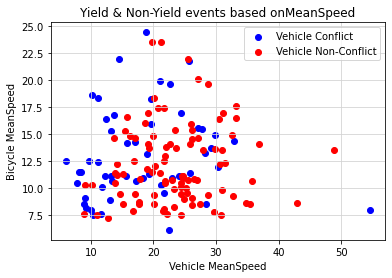

In [76]:
# --- Bicycle ----
bicycleEvents = getConflictBycicleEvent()
bicycleMeanSpeed = getMeanSpeedForAllInstances(bicycleEvents)
print('Bycicle conflict events mean speed: ', bicycleMeanSpeed)

bicycleSpeedStandardDeviation = getStandardDeviationForAllInstances(bicycleEvents)
print('Bycicle speed standard deviation: ', bicycleSpeedStandardDeviation)
print('\n')

# --- Vehicle ----
vehicleEvents = getConflictVehicleEvent()
vehicleMeanSpeed = getMeanSpeedForAllInstances(vehicleEvents)
print('Vehicle conflict events mean speed: ', vehicleMeanSpeed)

vehicleSpeedStandardDeviation = getStandardDeviationForAllInstances(vehicleEvents)
print('Vehicle speed standard deviation: ', vehicleSpeedStandardDeviation)


plotConflictAndNonConflictEventsBasedOnFeature('MeanSpeed')



##### Yield

Number of interactions (possible conflict events):  150
Number of interactions (possible conflict events):  150
Bycicle mean speed when car yielded:  13.08922974085696
Bycicle speed standard deviation:  3.9170613335027147


Number of interactions (possible conflict events):  150
Number of interactions (possible conflict events):  150
Number of interactions (possible conflict events):  150


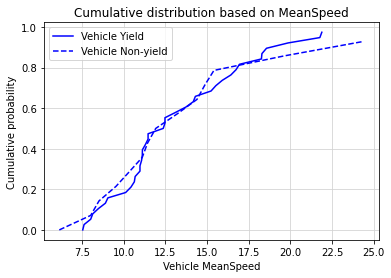



Number of interactions (possible conflict events):  150
Vehicle yield events mean speed:  14.77490731855364
Vehicle speed standard deviation:  5.818447163334324
Number of interactions (possible conflict events):  150
Number of interactions (possible conflict events):  150
Number of interactions (possible conflict events):  150
Number of interactions (possible conflict events):  150
Number of interactions (possible conflict events):  150


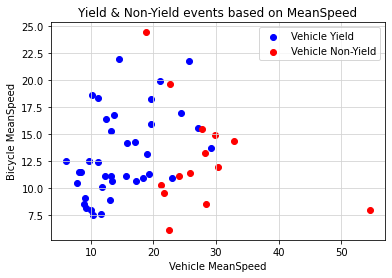

Number of interactions (possible conflict events):  150
Number of interactions (possible conflict events):  150


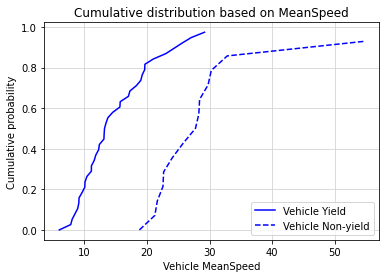

In [77]:
# --- Bicycle ----
bicycleEvents = getYieldBycicleEvent()
bicycleMeanSpeed = getMeanSpeedForAllInstances(bicycleEvents)
print('Bycicle mean speed when car yielded: ', bicycleMeanSpeed)

bicycleSpeedStandardDeviation = getStandardDeviationForAllInstances(bicycleEvents)
print('Bycicle speed standard deviation: ', bicycleSpeedStandardDeviation)
print('\n')

CDFPlot = plotYieldCumulativeDistributionBasedOnFeature('MeanSpeed', aboutVehicle=False)
CDFPlot.show()
print('\n')


# --- Vehicle ----
vehicleEvents = getYieldVehicleEvent()
vehicleMeanSpeed = getMeanSpeedForAllInstances(vehicleEvents)
print('Vehicle yield events mean speed: ', vehicleMeanSpeed)

vehicleSpeedStandardDeviation = getStandardDeviationForAllInstances(vehicleEvents)
print('Vehicle speed standard deviation: ', vehicleSpeedStandardDeviation)


scatterPlot = plotYieldAndNonYieldEventsBasedOnFeature('MeanSpeed')
scatterPlot.show()

CDFPlot = plotYieldCumulativeDistributionBasedOnFeature('MeanSpeed')
CDFPlot.show()


##### Non-yield 

In [78]:
# --- Bicycle ----
bicycleEvents = getNonYieldBycicleEvent()
bicycleMeanSpeed = getMeanSpeedForAllInstances(bicycleEvents)
print('Bycicle mean speed when car did not yield: ', bicycleMeanSpeed)

bicycleSpeedStandardDeviation = getStandardDeviationForAllInstances(bicycleEvents)
print('Bycicle speed standard deviation: ', bicycleSpeedStandardDeviation)
print('\n')

# --- Vehicle ----
vehicleEvents = getNonYieldVehicleEvent()
vehicleMeanSpeed = getMeanSpeedForAllInstances(vehicleEvents)
print('Vehicle non-yield events mean speed: ', vehicleMeanSpeed)

vehicleSpeedStandardDeviation = getStandardDeviationForAllInstances(vehicleEvents)
print('Vehicle speed standard deviation: ', vehicleSpeedStandardDeviation)


Number of interactions (possible conflict events):  150
Bycicle mean speed when car did not yield:  12.784073278332096
Bycicle speed standard deviation:  4.826988067693563


Number of interactions (possible conflict events):  150
Vehicle non-yield events mean speed:  27.778204297332
Vehicle speed standard deviation:  8.720754488513546


## Bicycle Distance from Conflict Zone

### Distance from CZ when vehicle entered the IZ



In [79]:
def getMeanDistanceFromCZForAllInstances(data):
    mean = data["distanceFromCZWhenOtherAgentEnteredIZ"].mean()
    return mean

# Find standard deviation of distance from CZ when first agent entered
def getStandardDeviationForAllInstances(data):
    standardDeviation = data["distanceFromCZWhenOtherAgentEnteredIZ"].std()
    return standardDeviation

#### Yield

Number of interactions (possible conflict events):  150
Number of interactions (possible conflict events):  150
Bycicle distance from CZ when car entered IZ:  9.432348840288928
Bycicle standard deviation:  8.543228714985402


Number of interactions (possible conflict events):  150
Number of interactions (possible conflict events):  150
Number of interactions (possible conflict events):  150
Number of interactions (possible conflict events):  150
Number of interactions (possible conflict events):  150


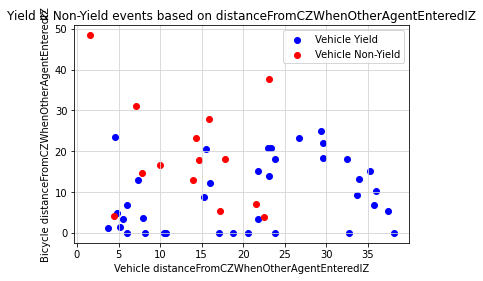

In [80]:
# --- Bicycle ----
bicycleEvents = getYieldBycicleEvent()
bicycle = getMeanDistanceFromCZForAllInstances(bicycleEvents)
print('Bycicle distance from CZ when car entered IZ: ', bicycle)

bicycleStandardDeviation = getStandardDeviationForAllInstances(bicycleEvents)
print('Bycicle standard deviation: ', bicycleStandardDeviation)
print('\n')

plot = plotYieldAndNonYieldEventsBasedOnFeature('distanceFromCZWhenOtherAgentEnteredIZ')
plot.show()

### Distance from CZ when first agent entered the IZ

In [81]:
def getMeanDistanceFromCZForAllInstances(data):
    mean = data["distanceFromCZWhenFirstAgentEnteredIZ"].mean()
    return mean

# Find standard deviation of distance from CZ when first agent entered
def getStandardDeviationForAllInstances(data):
    standardDeviation = data["distanceFromCZWhenFirstAgentEnteredIZ"].std()
    return standardDeviation

##### Yield 

Number of interactions (possible conflict events):  150
Number of interactions (possible conflict events):  150
Bycicle distance from CZ when car entered IZ:  13.908078414674902
Bycicle standard deviation:  5.599826700810457


Number of interactions (possible conflict events):  150
Number of interactions (possible conflict events):  150
Number of interactions (possible conflict events):  150
Number of interactions (possible conflict events):  150
Number of interactions (possible conflict events):  150


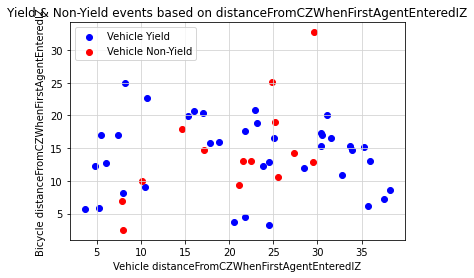

In [82]:
# --- Bicycle ----
bicycleEvents = getYieldBycicleEvent()
bicycle = getMeanDistanceFromCZForAllInstances(bicycleEvents)
print('Bycicle distance from CZ when car entered IZ: ', bicycle)

bicycleStandardDeviation = getStandardDeviationForAllInstances(bicycleEvents)
print('Bycicle standard deviation: ', bicycleStandardDeviation)
print('\n')

# --- Vehicle ----
# vehicleEvents = getYieldVehicleEvent()
# vehicle = getMeanDistanceFromCZForAllInstances(vehicleEvents)
# print('Vehicle distance from CZ when car entered IZ: ', vehicle)

#vehicleStandardDeviation = getStandardDeviationForAllInstances(vehicleEvents)
#print('Vehicle speed standard deviation: ', vehicleStandardDeviation)


Number of interactions (possible conflict events):  150
Number of interactions (possible conflict events):  150
Number of interactions (possible conflict events):  150
Number of interactions (possible conflict events):  150
Number of interactions (possible conflict events):  150


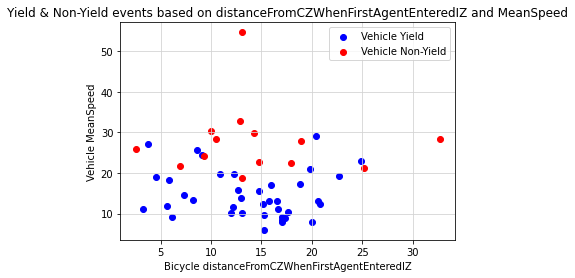

In [119]:
bicycleEvents = getYieldBycicleEvent()
bicycleNonYieldEvents = getNonYieldBycicleEvent()
vehicleEvents = getYieldVehicleEvent()
vehicleNonYieldEvents = getNonYieldVehicleEvent()



plt.xlabel('Bicycle distanceFromCZWhenFirstAgentEnteredIZ') 
plt.ylabel('Vehicle MeanSpeed')

plt.title('Yield & Non-Yield events based on distanceFromCZWhenFirstAgentEnteredIZ and MeanSpeed') 

length = len(bicycleEvents)
fake_vehicle_distance = np.full(length, 20, dtype=int)

length2 = len(bicycleNonYieldEvents)
fake_vehicle_distance2 = np.full(length2, 20, dtype=int)

plt.scatter(bicycleEvents['distanceFromCZWhenFirstAgentEnteredIZ'], vehicleEvents['MeanSpeed'], color='blue', label="Vehicle Yield")
plt.scatter(bicycleNonYieldEvents['distanceFromCZWhenFirstAgentEnteredIZ'], vehicleNonYieldEvents['MeanSpeed'], color='red', label="Vehicle Non-Yield")

plt.grid(b=True, color='#D3D3D3')
plt.legend()

##### Non-yield 

In [83]:
# --- Bicycle ----
bicycleEvents = getNonYieldBycicleEvent()
bicycle = getMeanDistanceFromCZForAllInstances(bicycleEvents)
print('Bycicle distance from CZ when car entered IZ: ', bicycle)

bicycleStandardDeviation = getStandardDeviationForAllInstances(bicycleEvents)
print('Bycicle standard deviation: ', bicycleStandardDeviation)
print('\n')

Number of interactions (possible conflict events):  150
Bycicle distance from CZ when car entered IZ:  14.443911566591984
Bycicle standard deviation:  7.579703822143776




##### Non-conflict

In [84]:
# --- Bicycle ----
bicycleEvents = getNonConflictBycicleEvent()
bicycle = getMeanDistanceFromCZForAllInstances(bicycleEvents)
print('Bycicle distance from CZ when car entered IZ: ', bicycle)

bicycleStandardDeviation = getStandardDeviationForAllInstances(bicycleEvents)
print('Bycicle standard deviation: ', bicycleStandardDeviation)
print('\n')

Number of interactions (possible conflict events):  150
Bycicle distance from CZ when car entered IZ:  16.0964838760143
Bycicle standard deviation:  5.765771988219583




##### Conflict

In [85]:
# --- Bicycle ----
bicycleEvents = getConflictBycicleEvent()
bicycle = getMeanDistanceFromCZForAllInstances(bicycleEvents)
print('Bycicle distance from CZ when first agnt entered IZ: ', bicycle)

bicycleStandardDeviation = getStandardDeviationForAllInstances(bicycleEvents)
print('Bycicle standard deviation: ', bicycleStandardDeviation)
print('\n')

Number of interactions (possible conflict events):  150
Bycicle distance from CZ when first agnt entered IZ:  14.05234118634488
Bycicle standard deviation:  6.119817448594434




## Minimum speed distance

In [86]:
def getMeanForAllInstances(data):
    mean = data["minSpeedDistance"].mean()
    return mean

# Find standard deviation of distance from CZ when first agent entered
def getStandardDeviationForAllInstances(data):
    standardDeviation = data["minSpeedDistance"].std()
    return standardDeviation

##### Yield

Number of interactions (possible conflict events):  150
Vehicle min speed distance from CZ:  16.63209361209278
Vehicle standard deviation:  8.331992566784736
Number of interactions (possible conflict events):  150
Number of interactions (possible conflict events):  150
Number of interactions (possible conflict events):  150
Number of interactions (possible conflict events):  150
Number of interactions (possible conflict events):  150


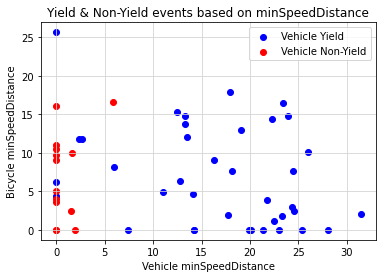

Number of interactions (possible conflict events):  150
Number of interactions (possible conflict events):  150


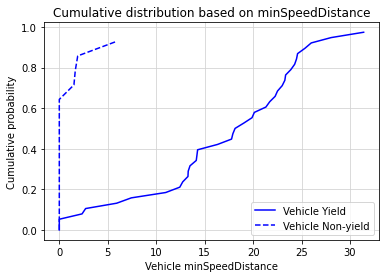

In [87]:
# --- Vehicle ----
vehicleEvents = getYieldVehicleEvent()
vehicle = getMeanForAllInstances(vehicleEvents)
print('Vehicle min speed distance from CZ: ', vehicle)

vehicleStandardDeviation = getStandardDeviationForAllInstances(vehicleEvents)
print('Vehicle standard deviation: ', vehicleStandardDeviation)

minSpeedDistPlot = plotYieldAndNonYieldEventsBasedOnFeature('minSpeedDistance')
minSpeedDistPlot.show()

CDFPlot = plotYieldCumulativeDistributionBasedOnFeature('minSpeedDistance')
CDFPlot.show()


* As mentioned in Bella et al. paper the vehicle min speed distance should become larger in case driver notices the bicycle from a longer distance. This could be the case here as well.

##### Non-yield

In [88]:
# --- Vehicle ----
vehicleEvents = getNonYieldVehicleEvent()
vehicle = getMeanForAllInstances(vehicleEvents)
print('Vehicle min speed distance from CZ: ', vehicle)

vehicleStandardDeviation = getStandardDeviationForAllInstances(vehicleEvents)
print('Vehicle standard deviation: ', vehicleStandardDeviation)


Number of interactions (possible conflict events):  150
Vehicle min speed distance from CZ:  0.7836008147659206
Vehicle standard deviation:  1.6387375103670656


##### Conflict

In [89]:
# --- Vehicle ----
vehicleEvents = getConflictVehicleEvent()
vehicle = getMeanForAllInstances(vehicleEvents)
print('Vehicle min speed distance from CZ: ', vehicle)

vehicleStandardDeviation = getStandardDeviationForAllInstances(vehicleEvents)
print('Vehicle standard deviation: ', vehicleStandardDeviation)



Number of interactions (possible conflict events):  150
Vehicle min speed distance from CZ:  12.365191705120164
Vehicle standard deviation:  10.071547314175037


##### Non-conflict

In [90]:
# --- Vehicle ----
vehicleEvents = getNonConflictVehicleEvent()
vehicle = getMeanForAllInstances(vehicleEvents)
print('Vehicle min speed distance from CZ: ', vehicle)

vehicleStandardDeviation = getStandardDeviationForAllInstances(vehicleEvents)
print('Vehicle standard deviation: ', vehicleStandardDeviation)


Number of interactions (possible conflict events):  150
Vehicle min speed distance from CZ:  5.615995615398639
Vehicle standard deviation:  9.325314224333718


## Minimum speed inside IZ

In [108]:
def getMeanForAllInstances(data):
    mean = data["minSpeedInsideInteractionZone"].mean()
    return mean

# Find standard deviation of distance from CZ when first agent entered
def getStandardDeviationForAllInstances(data):
    standardDeviation = data["minSpeedInsideInteractionZone"].std()
    return standardDeviation

##### Yield

Number of interactions (possible conflict events):  150
Vehicle min speed inside IZ:  7.517969577434365
Vehicle standard deviation:  6.609638925156344
Number of interactions (possible conflict events):  150
Number of interactions (possible conflict events):  150
Number of interactions (possible conflict events):  150
Number of interactions (possible conflict events):  150
Number of interactions (possible conflict events):  150


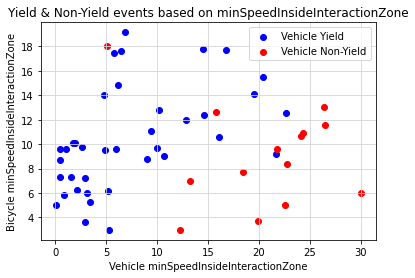

Number of interactions (possible conflict events):  150
Number of interactions (possible conflict events):  150


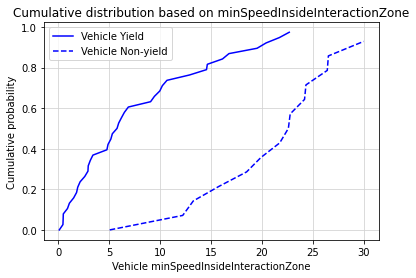

In [109]:
# --- Vehicle ----
vehicleEvents = getYieldVehicleEvent()
vehicle = getMeanForAllInstances(vehicleEvents)
print('Vehicle min speed inside IZ: ', vehicle)

vehicleStandardDeviation = getStandardDeviationForAllInstances(vehicleEvents)
print('Vehicle standard deviation: ', vehicleStandardDeviation)

minSpeedDistPlot = plotYieldAndNonYieldEventsBasedOnFeature('minSpeedInsideInteractionZone')
minSpeedDistPlot.show()

CDFPlot = plotYieldCumulativeDistributionBasedOnFeature('minSpeedInsideInteractionZone')
CDFPlot.show()


##### Non-yield

In [110]:
# --- Vehicle ----
vehicleEvents = getNonYieldVehicleEvent()
vehicle = getMeanForAllInstances(vehicleEvents)
print('Vehicle min speed inside IZ: ', vehicle)

vehicleStandardDeviation = getStandardDeviationForAllInstances(vehicleEvents)
print('Vehicle standard deviation: ', vehicleStandardDeviation)


Number of interactions (possible conflict events):  150
Vehicle min speed inside IZ:  20.236384921929282
Vehicle standard deviation:  6.719659001392107


## Bicycle Distance from CZ when vehicle enters the IZ

In [111]:
def getMeanForAllInstances(data):
    mean = data["distanceFromCZWhenOtherAgentEnteredIZ"].mean()
    return mean

# Find standard deviation of distance from CZ when first agent entered
def getStandardDeviationForAllInstances(data):
    standardDeviation = data["distanceFromCZWhenOtherAgentEnteredIZ"].std()
    return standardDeviation

## Vehicle in Far Lane Relative to Bicycle

In [91]:
def getEventsWithAgentsComingFromOppositeSides(vehicleEvents, bicycleEvents):
    vehicle_data = vehicleEvents.copy()
    vehicle_data.set_index(keys='InteractionID', drop=False, inplace=True)
    
    for index, row in vehicle_data.iterrows():
        interactionID = row['InteractionID']
        
        # Vehicle
        if row['AgentType'] == 2:
            vehicleIZborder = row["initialInteractionZone"]
            
            bicycle = bicycleEvents.loc[(bicycleEvents['InteractionID'] == interactionID) & (bicycleEvents['AgentType'] == 1)]
            bicycleIZborder = bicycle['initialInteractionZone'].values[0]
            
            
            # Vehicle coming from East
            if (vehicleIZborder == 'VehicleIZBorder.KL' or vehicleIZborder == 'VehicleIZBorder.OP'):
                # Bicyce coming from South
                if (bicycleIZborder == 'BicycleIZBorder.EF'):
                    #print('all good: ', bicycleIZborder, vehicleIZborder)
                    continue
                else: 
                    vehicle_data.drop(index=[interactionID], inplace=True)

            # Vehicle coming from West IJ
            else:
                if (bicycleIZborder == 'BicycleIZBorder.GH' or bicycleIZborder == 'BicycleIZBorder.MN'):
                    #print('all good: ', bicycleIZborder, vehicleIZborder)
                    continue 
                else:
                    vehicle_data.drop(index=[interactionID], inplace=True)

    return vehicle_data


def getEventsWithAgentsComingFromSameSides(vehicleEvents, bicycleEvents):
    vehicle_data = vehicleEvents.copy()
    vehicle_data.set_index(keys='InteractionID', drop=False, inplace=True)
    
    for index, row in vehicle_data.iterrows():
        interactionID = row['InteractionID']
        
        # Vehicle
        if row['AgentType'] == 2:
            vehicleIZborder = row["initialInteractionZone"]
            
            bicycle = bicycleEvents.loc[(bicycleEvents['InteractionID'] == interactionID) & (bicycleEvents['AgentType'] == 1)]
            bicycleIZborder = bicycle['initialInteractionZone'].values[0]
            
            
            # Vehicle coming from East
            if (vehicleIZborder == 'VehicleIZBorder.KL' or vehicleIZborder == 'VehicleIZBorder.OP'):
                # Bicyce coming from South
                if (bicycleIZborder == 'BicycleIZBorder.GH' or bicycleIZborder == 'BicycleIZBorder.MN'):
                    #print('all good: ', bicycleIZborder, vehicleIZborder)
                    continue
                else: 
                    vehicle_data.drop(index=[interactionID], inplace=True)

            # Vehicle coming from West IJ
            else:
                if bicycleIZborder == 'BicycleIZBorder.EF':
                    #print('all good: ', bicycleIZborder, vehicleIZborder)
                    continue 
                else:
                    vehicle_data.drop(index=[interactionID], inplace=True)

    return vehicle_data

def percentage(numberOfAllEvents, eventsFromSameSide):
    return (100*len(eventsFromSameSide))/len(numberOfAllEvents)


##### Yield

In [92]:
# --- Vehicle ----
vehicleEvents = getYieldVehicleEvent()
bicycleEvents = getYieldBycicleEvent()

vehicleEventsFromOppositDirection = getEventsWithAgentsComingFromOppositeSides(vehicleEvents, bicycleEvents)
print('Number of interactions where vehicle & bicycle came from opposite direction:', 
      len(vehicleEventsFromOppositDirection), ' (out of all', len(vehicleEvents), 'yield events)')

print('Percentage of all events:', percentage(vehicleEvents, vehicleEventsFromOppositDirection))
print('\n')

# TODO: Would like to know the yielding probability 
# Plot different features of these events

vehicleEventsFromSameDirection = getEventsWithAgentsComingFromSameSides(vehicleEvents, bicycleEvents)
print('Number of interactions where vehicle & bicycle came from same direction:', 
      len(vehicleEventsFromSameDirection), ' (out of all', len(vehicleEvents), 'yield events)')

print('Percentage of all events:', percentage(vehicleEvents, vehicleEventsFromSameDirection))



Number of interactions (possible conflict events):  150
Number of interactions (possible conflict events):  150
Number of interactions (possible conflict events):  150
Number of interactions where vehicle & bicycle came from opposite direction: 23  (out of all 38 yield events)
Percentage of all events: 60.526315789473685


Number of interactions where vehicle & bicycle came from same direction: 15  (out of all 38 yield events)
Percentage of all events: 39.473684210526315


##### Non-yield

In [93]:
# --- Vehicle ----
vehicleEvents = getNonYieldVehicleEvent()
bicycleEvents = getNonYieldBycicleEvent()

vehicleEventsFromOppositeDirection = getEventsWithAgentsComingFromOppositeSides(vehicleEvents, bicycleEvents)
print('Number of interactions where vehicle & bicycle came from opposite direction:', 
      len(vehicleEventsFromOppositeDirection), ' (out of all', len(vehicleEvents), 'non-yield events)')

print('Percentage of all events:', percentage(vehicleEvents, vehicleEventsFromOppositeDirection))
print('\n')

vehicleEventsFromSameDirection = getEventsWithAgentsComingFromSameSides(vehicleEvents, bicycleEvents)
print('Number of interactions where vehicle & bicycle came from same direction:', 
      len(vehicleEventsFromSameDirection), ' (out of all', len(vehicleEvents), 'non-yield events)')

print('Percentage of all events:', percentage(vehicleEvents, vehicleEventsFromSameDirection))



Number of interactions (possible conflict events):  150
Number of interactions (possible conflict events):  150
Number of interactions where vehicle & bicycle came from opposite direction: 11  (out of all 14 non-yield events)
Percentage of all events: 78.57142857142857


Number of interactions where vehicle & bicycle came from same direction: 3  (out of all 14 non-yield events)
Percentage of all events: 21.428571428571427


##### Conflict

In [94]:
# --- Vehicle ----
vehicleEvents = getConflictVehicleEvent()
bicycleEvents = getConflictBycicleEvent()

vehicleEventsFromOppositeDirection = getEventsWithAgentsComingFromOppositeSides(vehicleEvents, bicycleEvents)
print('Number of interactions where vehicle & bicycle came from opposite direction:', 
      len(vehicleEventsFromOppositeDirection), ' (out of all', len(vehicleEvents), 'conflict events)')

print('Percentage of all events:', percentage(vehicleEvents, vehicleEventsFromOppositeDirection))
print('\n')

vehicleEventsFromSameDirection = getEventsWithAgentsComingFromSameSides(vehicleEvents, bicycleEvents)
print('Number of interactions where vehicle & bicycle came from same direction:', 
      len(vehicleEventsFromSameDirection), ' (out of all', len(vehicleEvents), 'conflict events)')

print('Percentage of all events:', percentage(vehicleEvents, vehicleEventsFromSameDirection))


Number of interactions (possible conflict events):  150
Number of interactions (possible conflict events):  150
Number of interactions where vehicle & bicycle came from opposite direction: 34  (out of all 52 conflict events)
Percentage of all events: 65.38461538461539


Number of interactions where vehicle & bicycle came from same direction: 18  (out of all 52 conflict events)
Percentage of all events: 34.61538461538461


##### Non-Conflict

In [95]:
# --- Vehicle ----
vehicleEvents = getNonConflictVehicleEvent()
bicycleEvents = getNonConflictBycicleEvent()

vehicleEventsFromOppositeDirection = getEventsWithAgentsComingFromOppositeSides(vehicleEvents, bicycleEvents)
print('Number of interactions where vehicle & bicycle came from opposite direction:', 
      len(vehicleEventsFromOppositeDirection), ' (out of all', len(vehicleEvents), 'non-conflict events)')

print('Percentage of all events:', percentage(vehicleEvents, vehicleEventsFromOppositeDirection))
print('\n')

vehicleEventsFromSameDirection = getEventsWithAgentsComingFromSameSides(vehicleEvents, bicycleEvents)
print('Number of interactions where vehicle & bicycle came from same direction:', 
      len(vehicleEventsFromSameDirection), ' (out of all', len(vehicleEvents), 'non-conflict events)')

print('Percentage of all events:', percentage(vehicleEvents, vehicleEventsFromSameDirection))


Number of interactions (possible conflict events):  150
Number of interactions (possible conflict events):  150
Number of interactions where vehicle & bicycle came from opposite direction: 61  (out of all 98 non-conflict events)
Percentage of all events: 62.244897959183675


Number of interactions where vehicle & bicycle came from same direction: 37  (out of all 98 non-conflict events)
Percentage of all events: 37.755102040816325


## Number of Bicycles

In [96]:
def plotYieldAndNonYieldEventsWithMultipleBicyclesBasedOnFeature(featureName):
    
    plt.xlabel('Vehicle ' + featureName) 
    plt.ylabel('Bicycle ' + featureName) 
    
    bicycleYieldEvents = getYieldBicycleEventsWithMultipleBicycles()
    bicycleNonYieldEvents = getNonYieldBicycleEventsWithMultipleBicycles()
    vehicleYieldEvents = getYieldVehicleEventsWithMultipleBicycles()
    vehicleNonYieldEvents = getNonYieldVehicleEventsWithMultipleBicycles()

    plt.title('Multiple bicycles Yield & Non-Yield events based on' + featureName) 

    plt.scatter(vehicleYieldEvents[featureName], bicycleYieldEvents[featureName], color='blue',
               label="Vehicle Yield")
    plt.scatter(vehicleNonYieldEvents[featureName], bicycleNonYieldEvents[featureName], color='red',
               label="Vehicle Non-Yield")

    plt.grid(b=True, color='#D3D3D3')
    plt.legend()
    
    return plt

In [97]:
def percentage(numberOfAllEvents, events):
    return (100*len(events))/len(numberOfAllEvents)


##### Conflict

In [98]:
conflictBicycleEventsWithMultipleBicycles = getConflictBicycleEventsWithMultipleBicycles()
print('Number of conflict events with multiple bicycles:', len(conflictBicycleEventsWithMultipleBicycles))

#conflictVehicleEventsWithMultipleBicycles = getConflictVehicleEventsWithMultipleBicycles()
#print('Number of conflict events with multiple bicycles:', len(conflictBicycleEventsWithMultipleBicycles))


Number of interactions (possible conflict events):  150
Number of conflict events with multiple bicycles: 15


##### Non-Conflict

In [99]:
nonConflictBicycleEventsWithMultipleBicycles = getNonConflictBicycleEventsWithMultipleBicycles()
print('Number of non-conflict events with multiple bicycles:', len(nonConflictBicycleEventsWithMultipleBicycles))


NameError: name 'getNonConflictBicycleEventsWithMultipleBicycles' is not defined

##### Yield

In [ ]:
#yieldBicycleEventsWithMultipleBicycles = getYieldBicycleEventsWithMultipleBicycles()
#print('Number of yield events with multiple bicycles:', len(yieldBicycleEventsWithMultipleBicycles))
#print('Percentage of yield events out of conflict events:', percentage(conflictBicycleEventsWithMultipleBicycles, yieldBicycleEventsWithMultipleBicycles))

#meanSpeedPlot = plotYieldAndNonYieldEventsWithMultipleBicyclesBasedOnFeature('MeanSpeed')
#meanSpeedPlot.show()
#minSpeedDistPlot = plotYieldAndNonYieldEventsWithMultipleBicyclesBasedOnFeature('minSpeedDistance')
#minSpeedDistPlot.show()


##### Non-Yield

In [ ]:
nonYieldBicycleEventsWithMultipleBicycles = getNonYieldBicycleEventsWithMultipleBicycles()
print('Number of events with multiple bicycles:', len(nonYieldBicycleEventsWithMultipleBicycles))
print('Percentage of non-yield events out of conflict events:', percentage(conflictBicycleEventsWithMultipleBicycles, nonYieldBicycleEventsWithMultipleBicycles))


## Speed at the border of interaction zone

In [ ]:
def getMeanSpeedAtTheBorderOfInteractionZoneForAllInstances(data):
    df = data["speedAtTheBorderOfInteractionZone"].mean()
    return df


##### Bicycle Speed At The Border Of Interaction Zone

In [ ]:
bicycleEvents = getBycicleEvents()
bicycleMeanSpeedAtTheBorderOfInteractionZone = getMeanSpeedAtTheBorderOfInteractionZoneForAllInstances(bicycleEvents)
print('Bycicle mean speed at the border of interaction zone: ', bicycleMeanSpeedAtTheBorderOfInteractionZone)


##### Vehicle Speed At The Border Of Interaction Zone

In [ ]:
vehicleEvents = getVehicleEvents()
vehicleMeanSpeedAtTheBorderOfInteractionZone = getMeanSpeedAtTheBorderOfInteractionZoneForAllInstances(vehicleEvents)
print('Vehicle mean speed at the border of interaction zone: ', vehicleMeanSpeedAtTheBorderOfInteractionZone)


##### Non-conflict Speed At The Border Of Interaction Zone

In [ ]:
bicycleEvents = getNonConflictBycicleEvent()
bicycleMeanSpeedAtTheBorderOfInteractionZone = getMeanSpeedAtTheBorderOfInteractionZoneForAllInstances(bicycleEvents)
print('Bycicle non-conflict event mean speed at the border of interaction zone: ', bicycleMeanSpeedAtTheBorderOfInteractionZone)


vehicleEvents = getNonConflictVehicleEvent()
vehicleMeanSpeedAtTheBorderOfInteractionZone = getMeanSpeedAtTheBorderOfInteractionZoneForAllInstances(vehicleEvents)
print('Vehicle non-conflict event mean speed at the border of interaction zone: ', vehicleMeanSpeedAtTheBorderOfInteractionZone)


##### Conflict Speed At The Border Of Interaction Zone

In [ ]:
bicycleEvents = getConflictBycicleEvent()
bicycleMeanSpeedAtTheBorderOfInteractionZone = getMeanSpeedAtTheBorderOfInteractionZoneForAllInstances(bicycleEvents)
print('Bycicle conflict events mean speed at the border of interaction zone: ', bicycleMeanSpeedAtTheBorderOfInteractionZone)


vehicleEvents = getConflictVehicleEvent()
vehicleMeanSpeedAtTheBorderOfInteractionZone = getMeanSpeedAtTheBorderOfInteractionZoneForAllInstances(vehicleEvents)
print('Vehicle conflict event mean speed at the border of interaction zone: ', vehicleMeanSpeedAtTheBorderOfInteractionZone)


##### Yield Speed At The Border Of Interaction Zone

In [ ]:
bicycleEvents = getYieldBycicleEvent()
bicycleMeanSpeedAtTheBorderOfInteractionZone = getMeanSpeedAtTheBorderOfInteractionZoneForAllInstances(bicycleEvents)
print('Bycicle yield events mean speed at the border of interaction zone: ', bicycleMeanSpeedAtTheBorderOfInteractionZone)


vehicleEvents = getYieldVehicleEvent()
vehicleMeanSpeedAtTheBorderOfInteractionZone = getMeanSpeedAtTheBorderOfInteractionZoneForAllInstances(vehicleEvents)
print('Vehicle yield events mean speed at the border of interaction zone: ', vehicleMeanSpeedAtTheBorderOfInteractionZone)



##### Non-yield Speed At The Border Of Interaction Zone

In [ ]:
bicycleEvents = getNonYieldBycicleEvent()
bicycleMeanSpeedAtTheBorderOfInteractionZone = getMeanSpeedAtTheBorderOfInteractionZoneForAllInstances(bicycleEvents)
print('Bycicle non-yield events mean speed at the border of interaction zone: ', bicycleMeanSpeedAtTheBorderOfInteractionZone)


vehicleEvents = getNonYieldVehicleEvent()
vehicleMeanSpeedAtTheBorderOfInteractionZone = getMeanSpeedAtTheBorderOfInteractionZoneForAllInstances(vehicleEvents)
print('Vehicle non-yield events mean speed at the border of interaction zone: ', vehicleMeanSpeedAtTheBorderOfInteractionZone)



## Min and Max speed inside the interaction zone

In [ ]:
def getMeanMinSpeedInsideInteractionZone(data):
    df = data["minSpeedInsideInteractionZone"].mean()
    return df

def getMeanMaxSpeedInsideInteractionZone(data):
    df = data["maxSpeedInsideInteractionZone"].mean()
    return df


##### Bicycle Min & Max Speed 

In [ ]:
bicycleEvents = getBycicleEvents()
bicycleMeanMinSpeedInsideInteractionZone = getMeanMinSpeedInsideInteractionZone(bicycleEvents)
print('Bycicle mean min speed inside interaction zone: ', bicycleMeanMinSpeedInsideInteractionZone)


bicycleMeanMaxSpeedInsideInteractionZone = getMeanMaxSpeedInsideInteractionZone(bicycleEvents)
print('Bycicle mean max speed inside interaction zone: ', bicycleMeanMaxSpeedInsideInteractionZone)



##### Vehicle Min & Max Speed 

In [ ]:
vehicleEvents = getVehicleEvents()
vehicleMeanMinSpeedInsideInteractionZone = getMeanMinSpeedInsideInteractionZone(vehicleEvents)
print('Vehicle mean min speed inside interaction zone: ', vehicleMeanMinSpeedInsideInteractionZone)

vehicleMeanMaxSpeedInsideInteractionZone = getMeanMaxSpeedInsideInteractionZone(vehicleEvents)
print('Vehicle mean max speed inside interaction zone: ', vehicleMeanMaxSpeedInsideInteractionZone)


##### Non-conflict Min & Max Speed 

In [ ]:
bicycleEvents = getNonConflictBycicleEvent()
bicycleMeanMinSpeedInsideInteractionZone = getMeanMinSpeedInsideInteractionZone(bicycleEvents)
print('Bycicle non-conflict events mean min speed inside interaction zone: ', bicycleMeanMinSpeedInsideInteractionZone)

bicycleMeanMaxSpeedInsideInteractionZone = getMeanMaxSpeedInsideInteractionZone(bicycleEvents)
print('Bycicle non-conflict events mean max speed inside interaction zone: ', bicycleMeanMaxSpeedInsideInteractionZone)
print('\n')


vehicleEvents = getNonConflictVehicleEvent()
vehicleMeanMinSpeedInsideInteractionZone = getMeanMinSpeedInsideInteractionZone(vehicleEvents)
print('Vehicle non-conflict events mean min speed inside interaction zone: ', vehicleMeanMinSpeedInsideInteractionZone)

vehicleMeanMaxSpeedInsideInteractionZone = getMeanMaxSpeedInsideInteractionZone(vehicleEvents)
print('Vehicle non-conflict events mean max speed inside interaction zone: ', vehicleMeanMaxSpeedInsideInteractionZone)



##### Conflict Min & Max Speed 

In [ ]:
bicycleEvents = getConflictBycicleEvent()
bicycleMeanMinSpeedInsideInteractionZone = getMeanMinSpeedInsideInteractionZone(bicycleEvents)
print('Bycicle conflict events mean min speed inside interaction zone: ', bicycleMeanMinSpeedInsideInteractionZone)

bicycleMeanMaxSpeedInsideInteractionZone = getMeanMaxSpeedInsideInteractionZone(bicycleEvents)
print('Bycicle conflict events mean max speed inside interaction zone: ', bicycleMeanMaxSpeedInsideInteractionZone)
print('\n')


vehicleEvents = getConflictVehicleEvent()
vehicleMeanMinSpeedInsideInteractionZone = getMeanMinSpeedInsideInteractionZone(vehicleEvents)
print('Vehicle conflict events mean min speed inside interaction zone: ', vehicleMeanMinSpeedInsideInteractionZone)

vehicleMeanMaxSpeedInsideInteractionZone = getMeanMaxSpeedInsideInteractionZone(vehicleEvents)
print('Vehicle conflict events mean max speed inside interaction zone: ', vehicleMeanMaxSpeedInsideInteractionZone)


It is interesting that bicycles min and max speed are both higher for conflict events than they are for non-conflcit events (For vehicles it is the opposite which seems logical).

##### Yield Min & Max Speed 

In [ ]:
bicycleEvents = getYieldBycicleEvent()
bicycleMeanMinSpeedInsideInteractionZone = getMeanMinSpeedInsideInteractionZone(bicycleEvents)
print('Bycicle yield events mean min speed inside interaction zone: ', bicycleMeanMinSpeedInsideInteractionZone)

bicycleMeanMaxSpeedInsideInteractionZone = getMeanMaxSpeedInsideInteractionZone(bicycleEvents)
print('Bycicle yield events mean max speed inside interaction zone: ', bicycleMeanMaxSpeedInsideInteractionZone)
print('\n')


vehicleEvents = getYieldVehicleEvent()
vehicleMeanMinSpeedInsideInteractionZone = getMeanMinSpeedInsideInteractionZone(vehicleEvents)
print('Vehicle yield events mean min speed inside interaction zone: ', vehicleMeanMinSpeedInsideInteractionZone)

vehicleMeanMaxSpeedInsideInteractionZone = getMeanMaxSpeedInsideInteractionZone(vehicleEvents)
print('Vehicle yield events mean max speed inside interaction zone: ', vehicleMeanMaxSpeedInsideInteractionZone)


##### Non-yield Min & Max Speed 

In [ ]:
bicycleEvents = getNonYieldBycicleEvent()
bicycleMeanMinSpeedInsideInteractionZone = getMeanMinSpeedInsideInteractionZone(bicycleEvents)
print('Bycicle non-yield events mean min speed inside interaction zone: ', bicycleMeanMinSpeedInsideInteractionZone)

bicycleMeanMaxSpeedInsideInteractionZone = getMeanMaxSpeedInsideInteractionZone(bicycleEvents)
print('Bycicle non-yield events mean max speed inside interaction zone: ', bicycleMeanMaxSpeedInsideInteractionZone)
print('\n')


vehicleEvents = getNonYieldVehicleEvent()
vehicleMeanMinSpeedInsideInteractionZone = getMeanMinSpeedInsideInteractionZone(vehicleEvents)
print('Vehicle non-yield events mean min speed inside interaction zone: ', vehicleMeanMinSpeedInsideInteractionZone)

vehicleMeanMaxSpeedInsideInteractionZone = getMeanMaxSpeedInsideInteractionZone(vehicleEvents)
print('Vehicle non-yield events mean max speed inside interaction zone: ', vehicleMeanMaxSpeedInsideInteractionZone)
